In [16]:
!ls
#https://ibb.co/HhyX9Yq
#!module load tensorflow=1.15.0

Desktop    GAN.jpg	       Pictures   Videos       mnist
Documents  GAN_tutorial.ipynb  Public	  __pycache__  ondemand
Downloads  Music	       Templates  foo.py


Introduction
------------

This tutorial is aimed at giving a thorough explanation of Generative Adversarial Network (GAN). First, we will understand the basic components of GAN through example where we try to generate images from random noise that looks like images from specific context. Then, we will try to design a GAN model that can generate high resolution images from low resolution images. 

??The first portion of the tutorial is mostly taken from  with some detailed explanation added. (add medium link??)

In order to go through this tutorial, some basic understanding of how deep learning will be useful. Also, it would help to have a GPU. Let us begin: 

Generative Adversarial Networks
-------------------------------

What is a GAN?

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper 'Generative Adversarial Nets <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>'.

GAN belongs to the set of algorithms named *Generative models*. These algorithms belong to the *Unsupervised Learning* class, which is a paradigm of ML where the model tries to learn the underlying structure of the input data without any available ground truth. So, given input data $x$, these algorithms try to learn the distribution function of the input data $p(x)$. This also allows them to generate new instances of inputs. In contrast, in *Supervised learning*, the model tries to learn the mapping function $y' = f(x)$, where the ground truth $y$ corresponding to input $x$ is available. However, these kind of models are not allowed to generate synthetic inputs.

The basic structure of a GAN is as follows: ![](GAN.jpg)

There are two main components in a GAN:

1) *Generator* **G**: This is a model that tries to generate new data similar to the real samples. It can be thought of as similar to a human art forger who tries to forge real artworks to fake ones and tries to sell them.

2) *Discriminator* **D**: This is a model that tries to classify the input data to whether it is real or fake. More specifically, given an input data, it tries to determine whether the data is from the real samples or whether the data is generated by **G**. It can be thought of similar to a human expert who can distinguish between real artworks and artworks faked by the forger. 

During training, **G** is continuously try to fool the discriminator by generating better and better fakes, while **D** tries to become a better detective and correctly classify the real and fake samples. The training reaches its saturation level when **G** is generating perfect
fakes those look as if they came directly from the real sample, and **D** is left to always guess at 50% confidence that the generator output is real or fake.

Mathematical Modeling
----------------------

Let us define some notations for GAN which will be used throughout the tutorial.

Let $z$ be a latent space vector (which we will probably generate using some kind of distribution). 

Let $x$ represent the real input space which is visible only to **D**.


**Notations for G**:


Let $G(z,\theta_1)$ represent the model which is used as the Generator. Here, $\theta_1$ represents the set of parameters associated with **G**. For example, if **G** is a feed forward neural network, then **\theta_1** is the weights associated with its layers.

So, given the latent space $z$, the generator performs a mapping $G(z)$ using the parameters $\theta_1$, which is used as the fake samples.

**Notations for D**:

Let $D(y,\theta_2)$ represent the model which is used as the Discriminator. Similar to **G**, here, $\theta_2$ represents the set of parameters associated with **D**. 

Given any input $y$, the discriminator performs a mapping $D(y)$ using the parameters $\theta_2$. Here, $D(y) \in (0,1)$. More specifically, given an input $y$, $D(y)$ is the probability of $y$ sampled from input space $x$. This means that given a sample, **D** tries to determine whether the sample is originated from real input space $x$ or from generator **G**.

**Altogether**:

Given an input $y$, $D(y)$ should be HIGH when $y$ is sampled from the real input space $x$ and $D(y)$ should be low when $y$ is generated from **G**.

Therefore, the goal of **D** is to maximize $D(x)$ and minimize $D(G(z))$. Or, we can say that, the goal of **D** is to maximize both $D(x)$ and $1-D(G(z))$.

Whereas, the goal of **G** is to generate such fake samples $G(z)$ so that $1-D(G(z))$ is minimized. 

So, we can see that **D** and **G** is playing a minimax game here. In Goodfellow's paper, the loss function of this game is defined as:

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

where $p_{data}(x)$ is the distribution of real training dataset $x$ and $p_{z}(z)$ is the distribution of the latent space.

In theory, the solution to this minimax game is reached when $p_{data} = p_z$ and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.

Now that we have a basic understanding of how GAN works, let us get into the coding part. We will first import the dependencies that we will need.

In [39]:
from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

from foo import Logger

The last package is a logger class designed by 'Diego Gomez' <https://github.com/diegoalejogm>. This will help us visualize some things that has happened during training the GAN.

**Dataset**:

For the dataset, we will be using MNIST dataset(cite MNIST here??). MNIST training dataset consists of 60,000 black and white images of handwritten digits. The images are of size $28 \times 28$. We will load this data with some preprocessing. To be specific, the image pixels have values from 0 to 255. However, we will be normalizing them.

First we download the dataset to a folder of our current directory.

In [40]:
mnist_trainset = datasets.MNIST(root='./mnist', train=True, download=True, transform=None)
print(mnist_trainset)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train


We can see that it says that there are a total of 60000 datapoints. Next, we apply normalization over it using a transformation function. We also create a dataloader for the dataset so that we can later iterate through the Dataset. Although, there was no need for the Resize transformation regarding the image size, it demonstraes how would you maybe want to resize the images to a different size.

In [52]:
image_size = 28

def get_transformed_data():
    data_dir = './mnist'
    transform=transforms.Compose([
       #transforms.Resize(image_size),
       #transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
    return datasets.MNIST(root=data_dir, train=True, transform = transform, download=False)

data = get_transformed_data()# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)
print(num_batches)

600


Next, we define the models of the GAN. 

**Discriminator D**:

The job of the discriminator was to take input and return the probability of the image being generated from the real dataset. In this case, the Discriminator will take an input image of the same dimension as the dataset in MNIST and output the probability whether the image belongs to the dataset we have defined just now or whether it belongs to a different domain.

So, first things first, the input layer of the Discriminator will have a size of ($28 \times 28 \times 1$) = $784$.

Regarding the overall structure of the rest of the network, it will have three linear layers. Each linear layer will have a ReLU non-linearity activation function associated with it. The last layer has a SigMoid activation function that will generate an output within range (0,1).


In [79]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_in = 784
        n_hidden_size_1 = 1024
        n_hidden_size_2 = 512
        n_out = 1
        
        self.inputLayer = nn.Sequential( 
            nn.Linear(n_in, n_hidden_size_1),
            nn.ReLU(inplace=True)
        )
        self.midLayer = nn.Sequential(
            nn.Linear(n_hidden_size_1, n_hidden_size_2),
            nn.ReLU(inplace=True)
        )
        self.outLayer = nn.Sequential(
            nn.Linear(n_hidden_size_2, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.midLayer(x)
        x = self.outLayer(x)
        return x
    
D = Discriminator()

We have defined the network. Let us just feed it with some random dummy inputs to see whether it produces outputs as desired and everything is well.

In [80]:
mock_input_batch = torch.zeros(10, 784).normal_(0, 0.02)
D.eval()
mock_output = D.forward(mock_input_batch)
D.train()
print(mock_input_batch.shape)
print(mock_output.shape)
print(mock_output)

torch.Size([10, 784])
torch.Size([10, 1])
tensor([[0.4901],
        [0.4906],
        [0.4902],
        [0.4903],
        [0.4901],
        [0.4904],
        [0.4906],
        [0.4908],
        [0.4906],
        [0.4898]], grad_fn=<SigmoidBackward>)


So, we can see that after feeding the discriminator with a batch of inputs, it is mapping each sample in the map to a probabilistic value in the range (0,1). So, the network is working as desired.

**Generator G**:

Similar to Discriminator **D**, we will also design the generator network **G**. Remember that the output of **G** will be fed as the input to **D**. So, the output of the generator will be of size 784. It will also be useful for the Generator outputs to have values in the same range that we normalized the MNIST dataset into. 

The MNIST dataset had values in the range (0,1). The normalization function had a mean and std of 0.5 each. For each pixel of the image this transform performs the mapping of $pixel = (pixel - mean) / std$. So, the minimum value 0 is mapped to -1 and the maximum value 1 is mapped to +1. So, the MNIST images have a value range of $[-1,1]$. Therefore, in the generator function, we will use a tanH activation function in the last layer which also conveniently produces output in the range $[-1,1]$.

In [81]:
n_latent_size = 100

class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_in = n_latent_size
        n_hidden_size_1 = 256
        n_hidden_size_2 = 512
        n_out = 784
        
        self.inputLayer = nn.Sequential( 
            nn.Linear(n_in, n_hidden_size_1),
            nn.ReLU(inplace=True)
        )
        self.midLayer = nn.Sequential(
            nn.Linear(n_hidden_size_1, n_hidden_size_2),
            nn.ReLU(inplace=True)
        )
        self.outLayer = nn.Sequential(
            nn.Linear(n_hidden_size_2, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.midLayer(x)
        x = self.outLayer(x)
        return x
    
G = Generator()

mock_input_batch = torch.zeros(10, 100).normal_(0, 0.02)
G.eval()
mock_output = G.forward(mock_input_batch)
G.train()
print(mock_input_batch.shape)
print(mock_output.shape)
#print(mock_output)
print(torch.min(mock_output))
print(torch.max(mock_output))

torch.Size([10, 100])
torch.Size([10, 784])
tensor(-0.0823, grad_fn=<MinBackward1>)
tensor(0.0926, grad_fn=<MaxBackward1>)


Note that the value of *n_latent_size* has been chosen arbitrarily. It actually represents the size of the data that will be sampled from the latent space by the Generator. You can change this value to see how the Generator learns to mimic the real input space with different such values. 

Below, we define a function that will create this random sample from the latent space and the output of this function will be fed as the input to the Generator.

In [82]:
def get_latent_sample(size):
    n = Variable(torch.randn(size, n_latent_size))
    return n

def ones_target(size):
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1))
    return data

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [83]:
learning_rate = 3e-4
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

In [84]:
loss = nn.BCELoss()

In [85]:
def train_D(optimizer, real_sample, G_sample):
    N = real_sample.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    real_score = D(real_sample)
    # Calculate error and backpropagate
    real_loss = loss(real_score, ones_target(N) )
    real_loss.backward()

    # Train on Fake Data
    fake_score = D(G_sample)
    # Calculate error and backpropagate
    fake_loss = loss(fake_score, zeros_target(N))
    fake_loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return real_loss + fake_loss, real_score, fake_score
#add some dummy test here

In [86]:
def train_G(optimizer, G_sample):
    N = G_sample.size(0)    
    
    # Reset gradients
    optimizer.zero_grad()    
    
    # Sample noise and generate fake data
    score = D(G_sample)    
    # Calculate error and backpropagate
    G_loss = loss(score, ones_target(N))
    G_loss.backward()    
    
    # Update weights with gradients
    optimizer.step()    
    
    # Return error
    return G_loss

In [87]:
num_test_samples = 16
test_noise = get_latent_sample(num_test_samples)

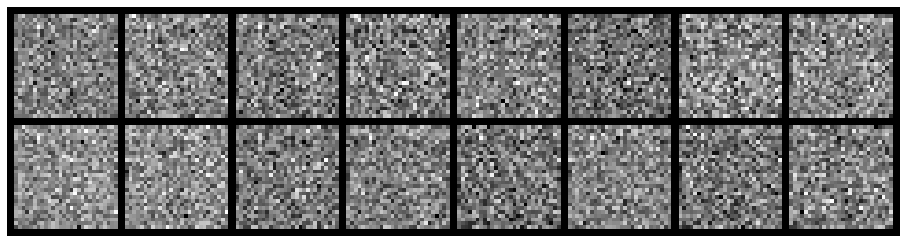

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 1.3084, Generator Loss: 0.7152
D(x): 0.5311, D(G(z)): 0.4911


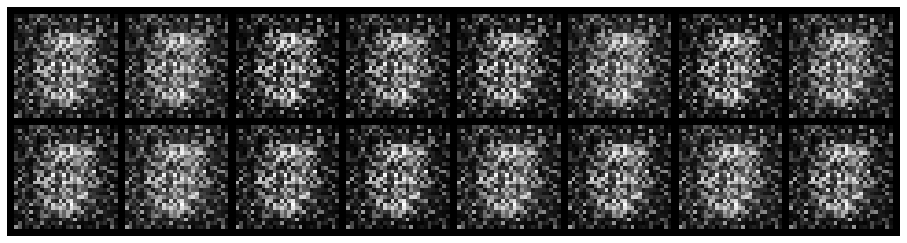

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 1.7332, Generator Loss: 2.7717
D(x): 0.9253, D(G(z)): 0.7553


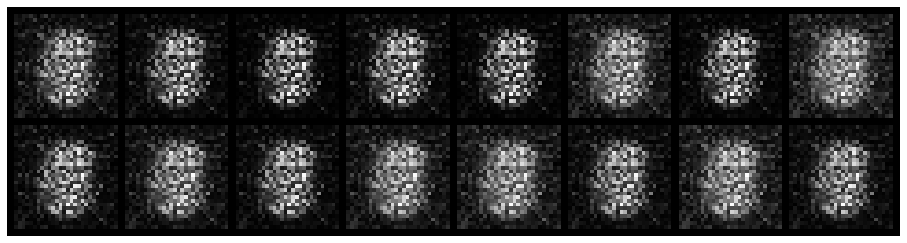

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 0.2711, Generator Loss: 4.7157
D(x): 0.8939, D(G(z)): 0.0766


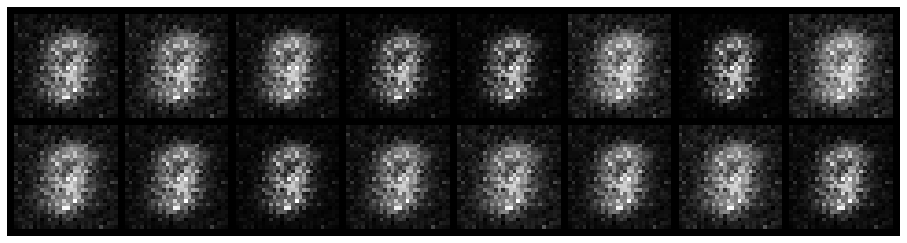

Epoch: [1/50], Batch Num: [300/600]
Discriminator Loss: 0.6754, Generator Loss: 2.4215
D(x): 0.8568, D(G(z)): 0.3044


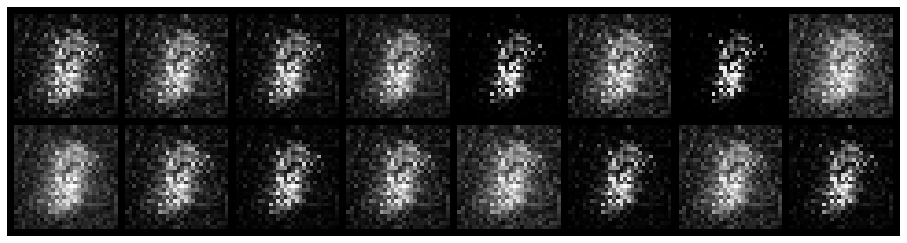

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 0.0868, Generator Loss: 4.8886
D(x): 0.9558, D(G(z)): 0.0112


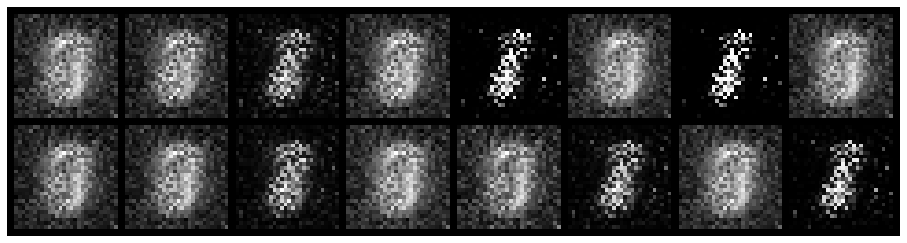

Epoch: [2/50], Batch Num: [300/600]
Discriminator Loss: 0.1157, Generator Loss: 4.0171
D(x): 0.9560, D(G(z)): 0.0447


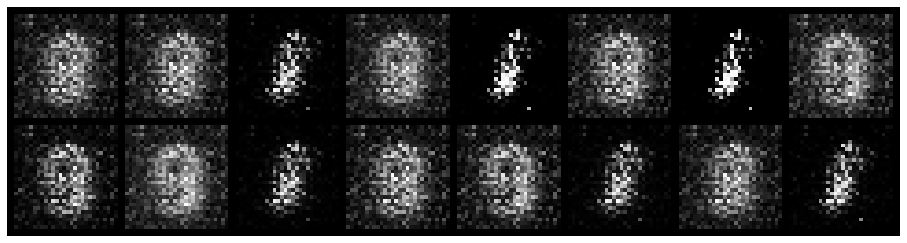

Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.1018, Generator Loss: 7.0059
D(x): 0.9410, D(G(z)): 0.0029


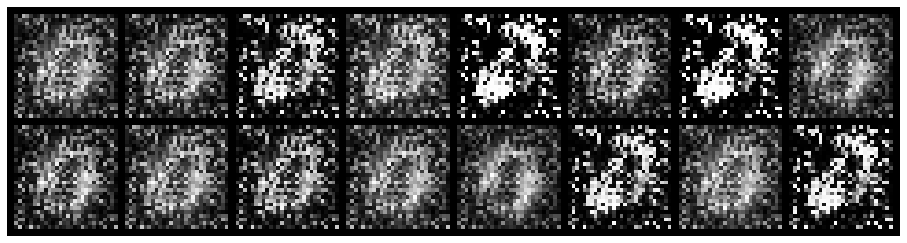

Epoch: [3/50], Batch Num: [300/600]
Discriminator Loss: 0.0748, Generator Loss: 7.3935
D(x): 0.9730, D(G(z)): 0.0110


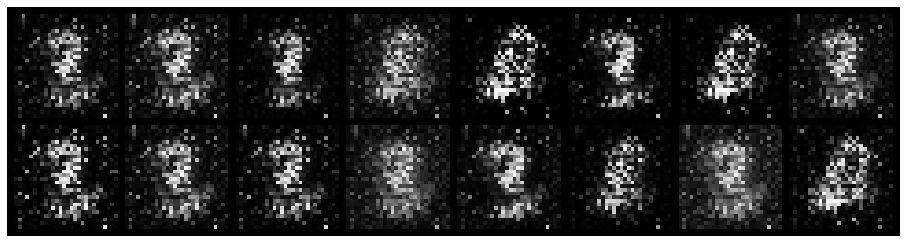

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 0.1201, Generator Loss: 5.6813
D(x): 0.9589, D(G(z)): 0.0338


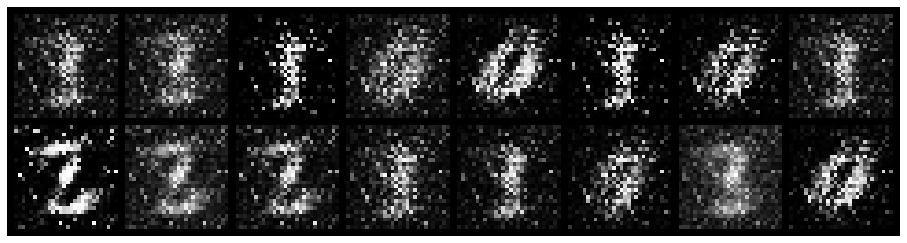

Epoch: [4/50], Batch Num: [300/600]
Discriminator Loss: 0.2834, Generator Loss: 6.6059
D(x): 0.9636, D(G(z)): 0.1571


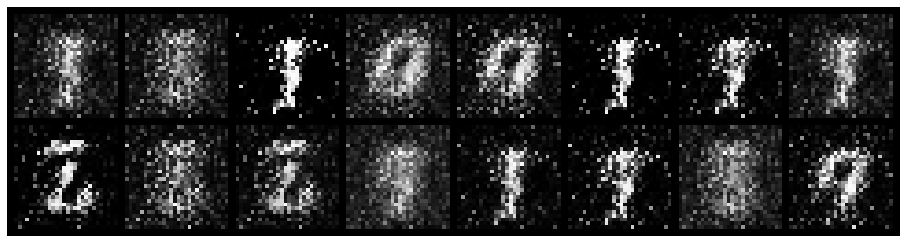

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.1557, Generator Loss: 5.8479
D(x): 0.9614, D(G(z)): 0.0631


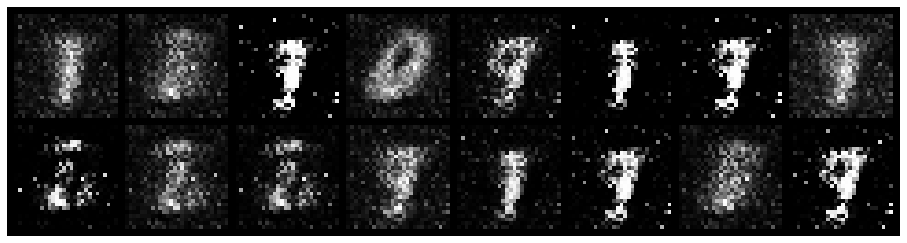

Epoch: [5/50], Batch Num: [300/600]
Discriminator Loss: 0.1490, Generator Loss: 3.5471
D(x): 0.9804, D(G(z)): 0.0740


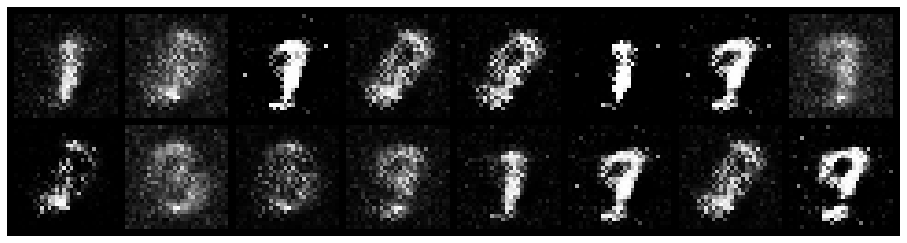

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.2288, Generator Loss: 4.0525
D(x): 0.9274, D(G(z)): 0.0431


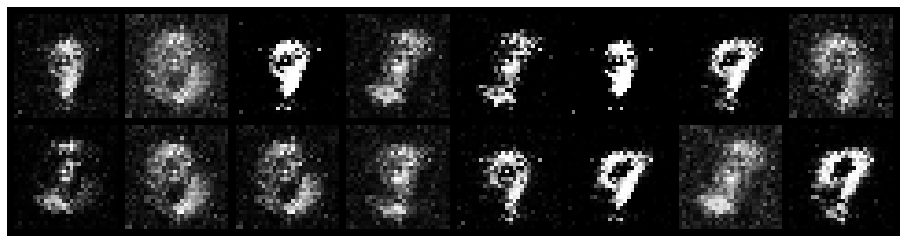

Epoch: [6/50], Batch Num: [300/600]
Discriminator Loss: 0.1839, Generator Loss: 5.0268
D(x): 0.9467, D(G(z)): 0.0646


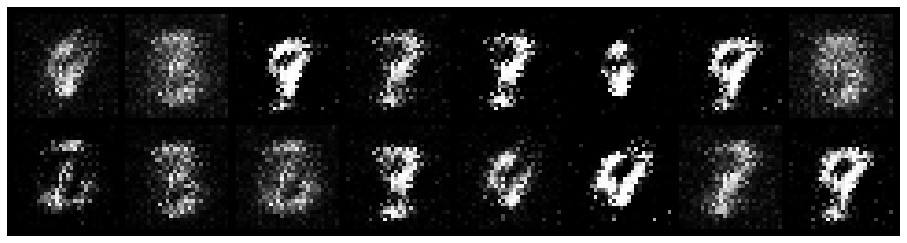

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 0.4818, Generator Loss: 4.6972
D(x): 0.8992, D(G(z)): 0.1441


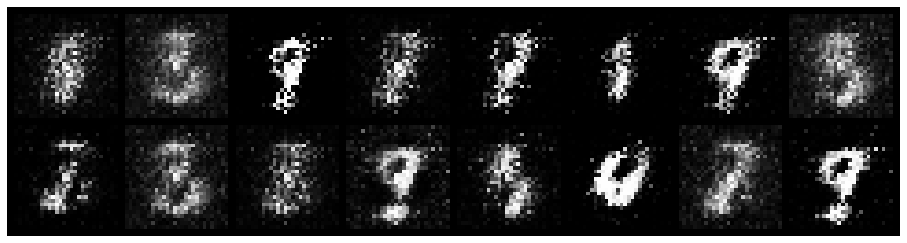

Epoch: [7/50], Batch Num: [300/600]
Discriminator Loss: 0.2511, Generator Loss: 5.3197
D(x): 0.9358, D(G(z)): 0.0410


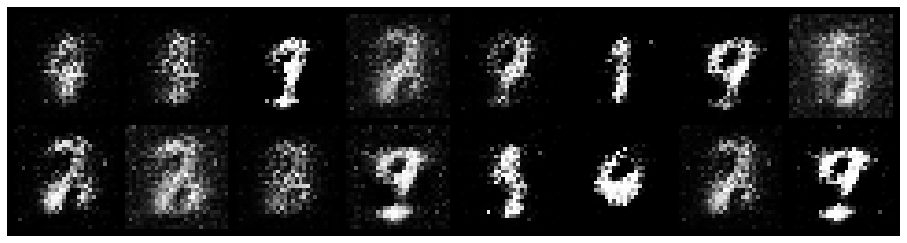

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 0.4156, Generator Loss: 3.8792
D(x): 0.9069, D(G(z)): 0.1952


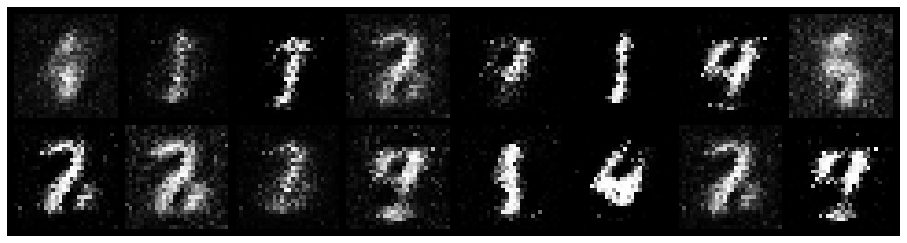

Epoch: [8/50], Batch Num: [300/600]
Discriminator Loss: 0.1939, Generator Loss: 2.8530
D(x): 0.9425, D(G(z)): 0.0744


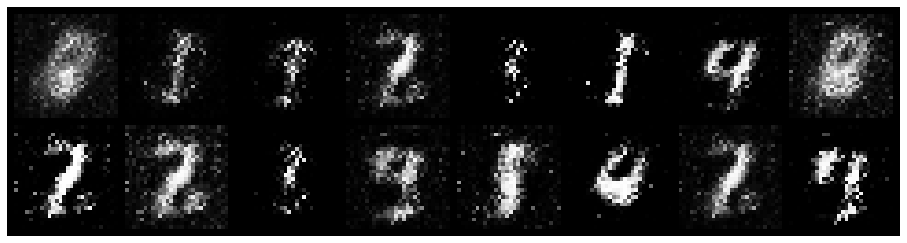

Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 0.7292, Generator Loss: 4.4479
D(x): 0.8746, D(G(z)): 0.2456


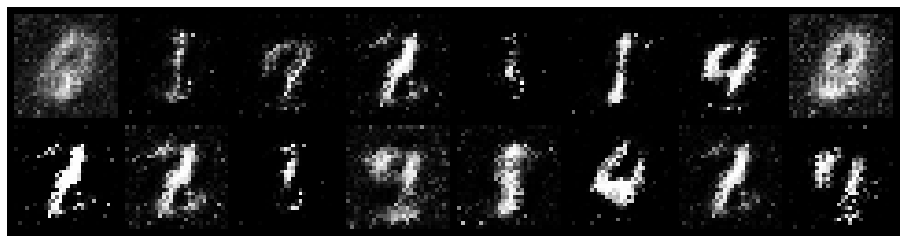

Epoch: [9/50], Batch Num: [300/600]
Discriminator Loss: 0.5244, Generator Loss: 3.5339
D(x): 0.8128, D(G(z)): 0.0380


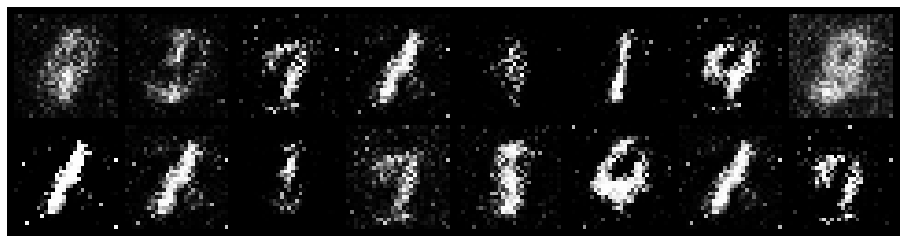

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 0.2617, Generator Loss: 5.0672
D(x): 0.9460, D(G(z)): 0.1168


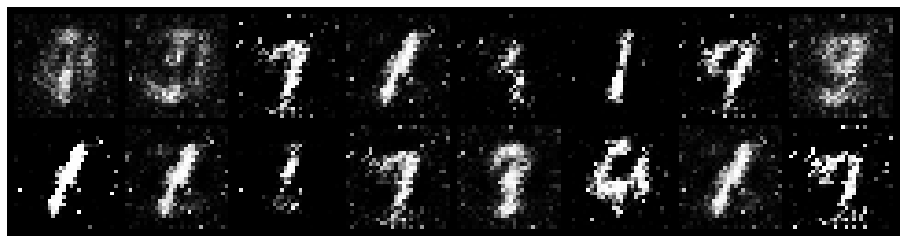

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 0.4426, Generator Loss: 5.5713
D(x): 0.9498, D(G(z)): 0.1988


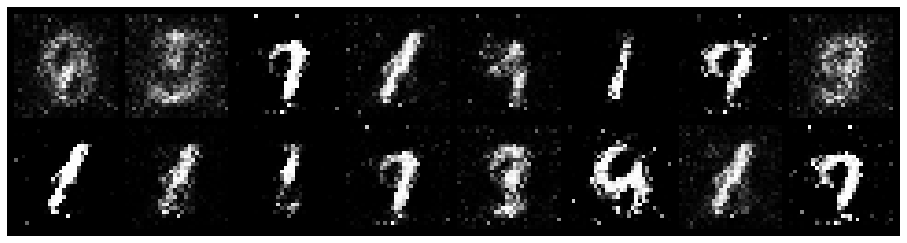

Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.4219, Generator Loss: 3.6914
D(x): 0.8923, D(G(z)): 0.1609


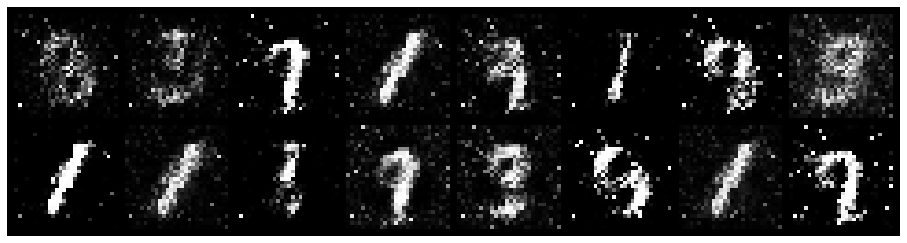

Epoch: [11/50], Batch Num: [300/600]
Discriminator Loss: 0.3407, Generator Loss: 3.3298
D(x): 0.9086, D(G(z)): 0.1080


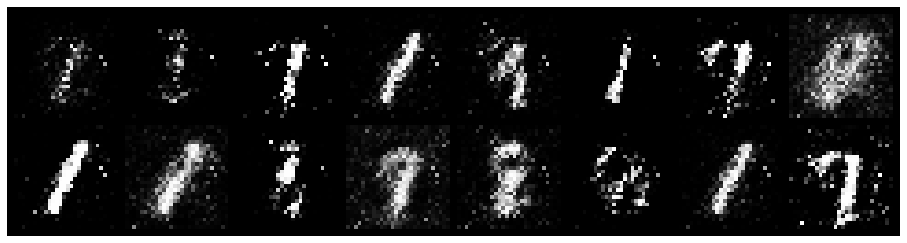

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.3931, Generator Loss: 2.6529
D(x): 0.8887, D(G(z)): 0.0921


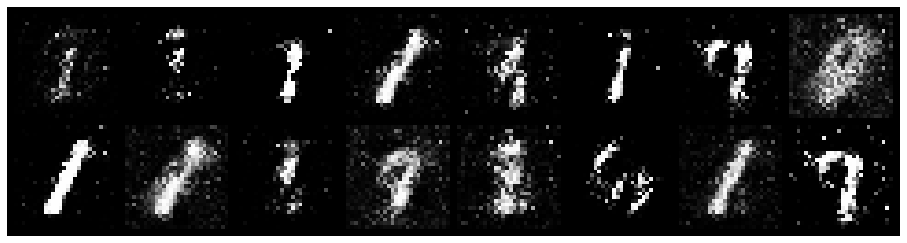

Epoch: [12/50], Batch Num: [300/600]
Discriminator Loss: 0.2421, Generator Loss: 5.9747
D(x): 0.9242, D(G(z)): 0.0757


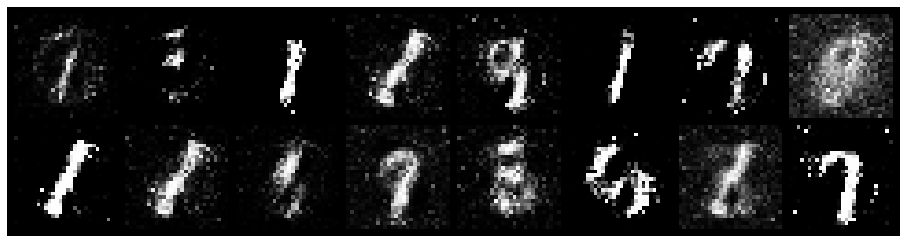

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 0.2871, Generator Loss: 3.4870
D(x): 0.9260, D(G(z)): 0.1195


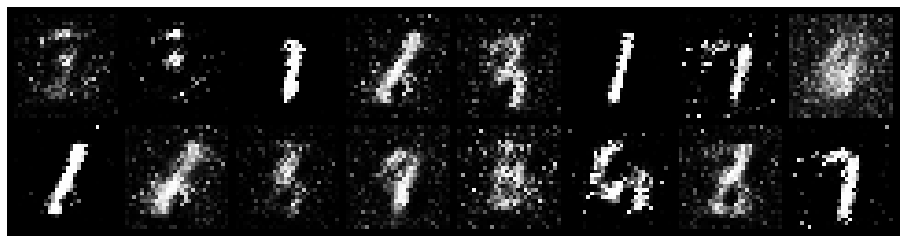

Epoch: [13/50], Batch Num: [300/600]
Discriminator Loss: 0.5706, Generator Loss: 3.5853
D(x): 0.8430, D(G(z)): 0.0896


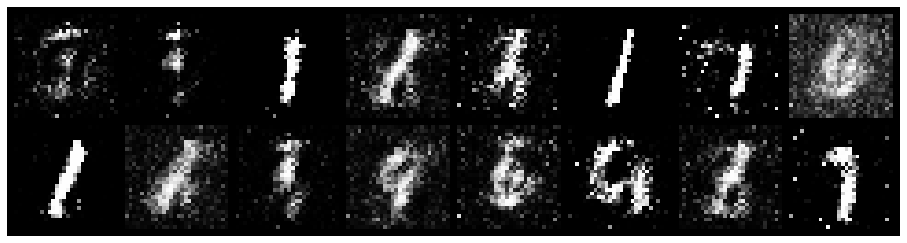

Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 0.4898, Generator Loss: 3.1390
D(x): 0.9286, D(G(z)): 0.2443


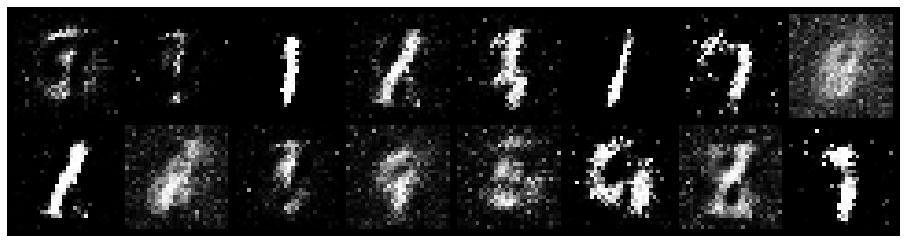

Epoch: [14/50], Batch Num: [300/600]
Discriminator Loss: 0.2419, Generator Loss: 3.3647
D(x): 0.9148, D(G(z)): 0.0824


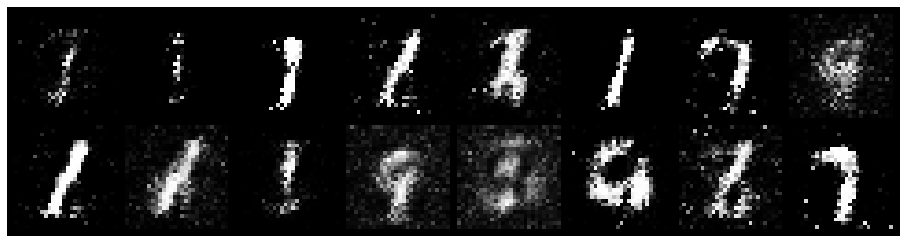

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 0.3890, Generator Loss: 4.5146
D(x): 0.8804, D(G(z)): 0.0804


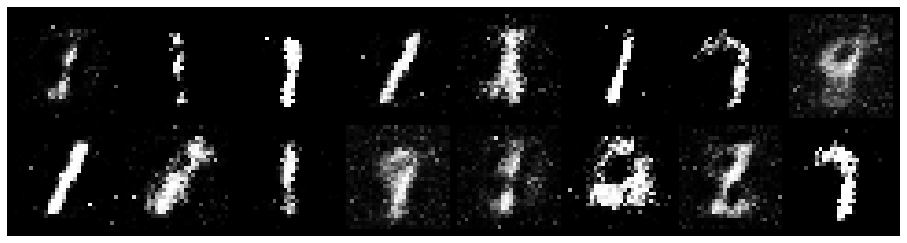

Epoch: [15/50], Batch Num: [300/600]
Discriminator Loss: 0.3982, Generator Loss: 2.8741
D(x): 0.8803, D(G(z)): 0.1567


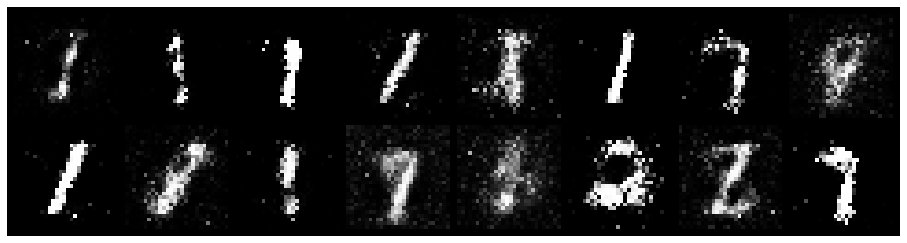

Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 0.2974, Generator Loss: 3.0017
D(x): 0.8917, D(G(z)): 0.0693


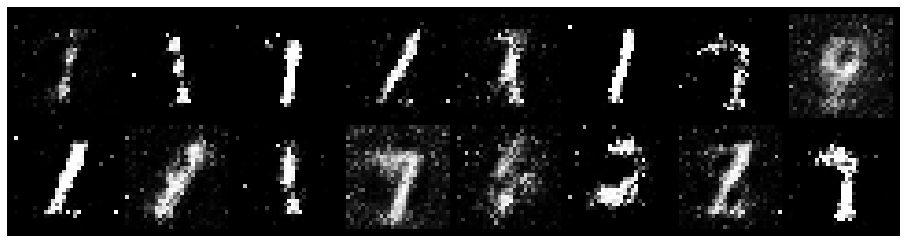

Epoch: [16/50], Batch Num: [300/600]
Discriminator Loss: 0.3972, Generator Loss: 4.9676
D(x): 0.9012, D(G(z)): 0.1652


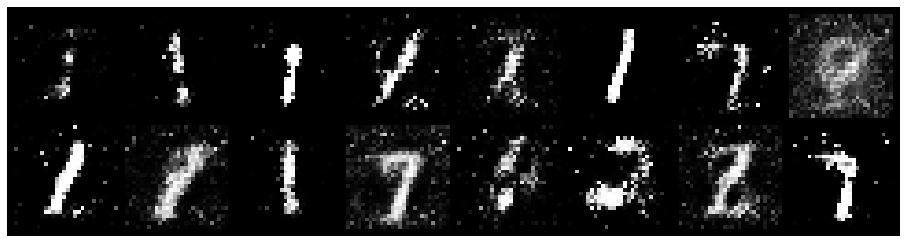

Epoch: [17/50], Batch Num: [0/600]
Discriminator Loss: 0.4355, Generator Loss: 4.2804
D(x): 0.8752, D(G(z)): 0.0888


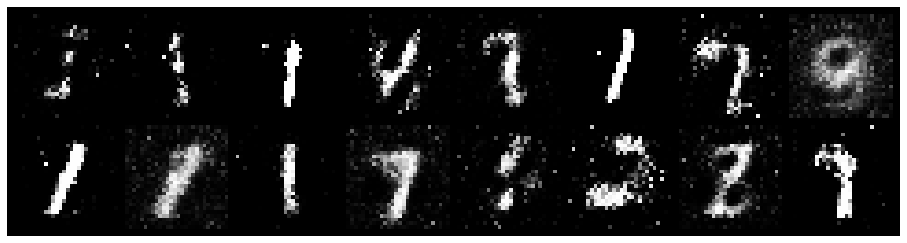

Epoch: [17/50], Batch Num: [300/600]
Discriminator Loss: 0.5337, Generator Loss: 2.7419
D(x): 0.8421, D(G(z)): 0.0821


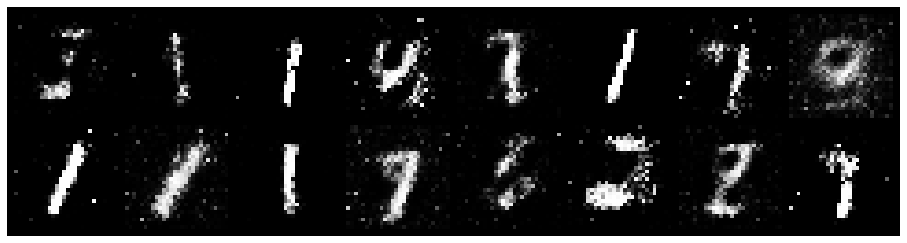

Epoch: [18/50], Batch Num: [0/600]
Discriminator Loss: 0.1612, Generator Loss: 4.8299
D(x): 0.9373, D(G(z)): 0.0619


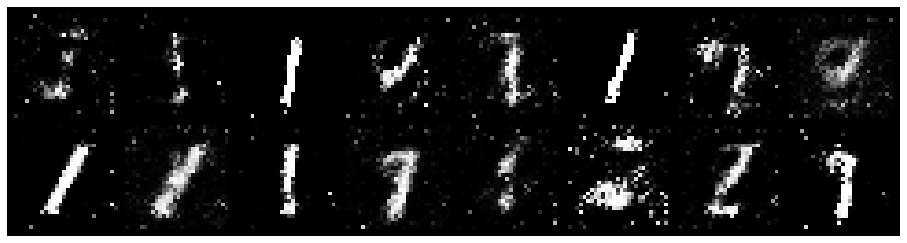

Epoch: [18/50], Batch Num: [300/600]
Discriminator Loss: 0.3282, Generator Loss: 3.1863
D(x): 0.9323, D(G(z)): 0.1667


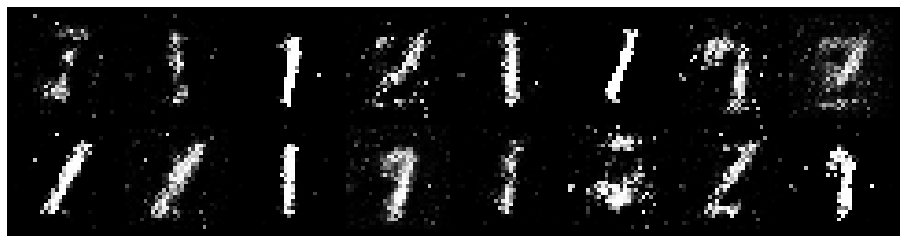

Epoch: [19/50], Batch Num: [0/600]
Discriminator Loss: 0.1747, Generator Loss: 4.1141
D(x): 0.9700, D(G(z)): 0.1012


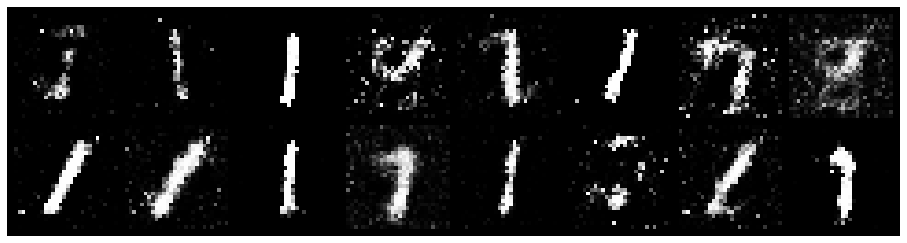

Epoch: [19/50], Batch Num: [300/600]
Discriminator Loss: 0.2293, Generator Loss: 4.7870
D(x): 0.8966, D(G(z)): 0.0485


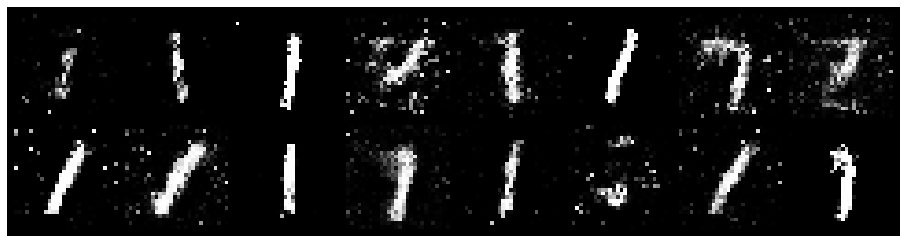

Epoch: [20/50], Batch Num: [0/600]
Discriminator Loss: 0.6519, Generator Loss: 1.7425
D(x): 0.8990, D(G(z)): 0.3173


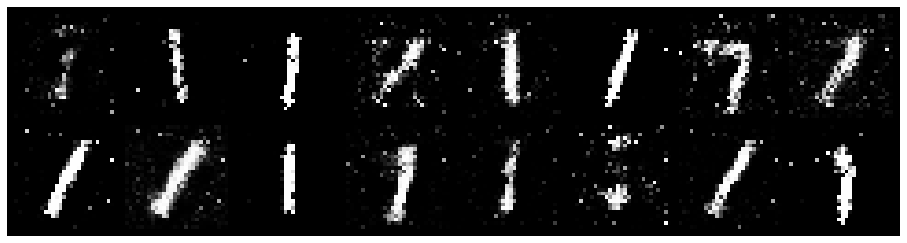

Epoch: [20/50], Batch Num: [300/600]
Discriminator Loss: 0.6015, Generator Loss: 3.4993
D(x): 0.9232, D(G(z)): 0.3007


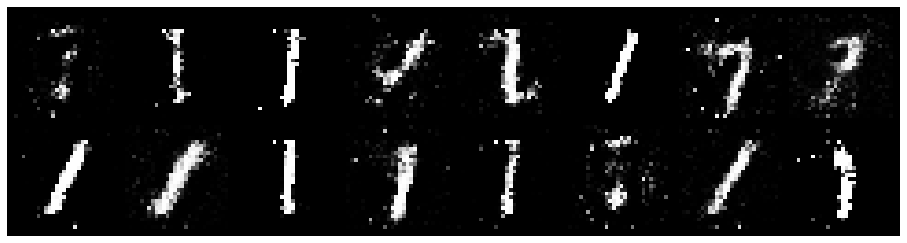

Epoch: [21/50], Batch Num: [0/600]
Discriminator Loss: 0.4527, Generator Loss: 3.1253
D(x): 0.8358, D(G(z)): 0.1206


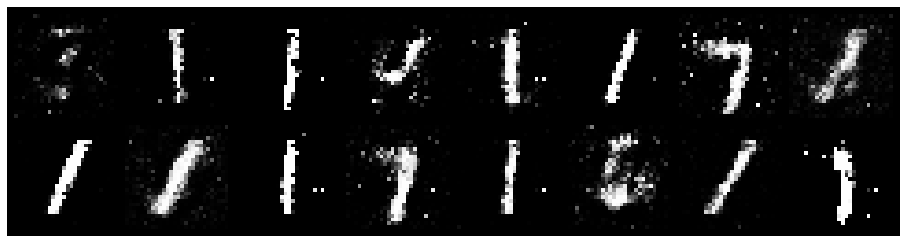

Epoch: [21/50], Batch Num: [300/600]
Discriminator Loss: 0.4547, Generator Loss: 2.6732
D(x): 0.8685, D(G(z)): 0.1323


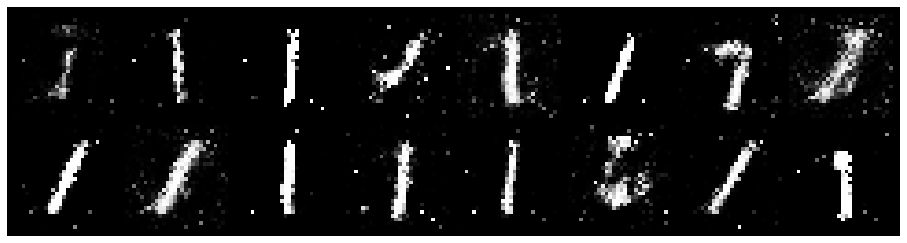

Epoch: [22/50], Batch Num: [0/600]
Discriminator Loss: 0.3324, Generator Loss: 2.8059
D(x): 0.8664, D(G(z)): 0.0506


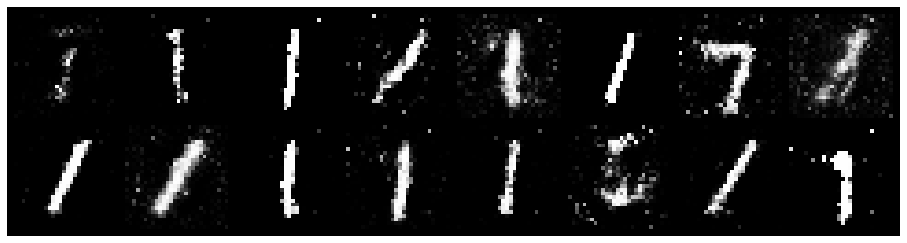

Epoch: [22/50], Batch Num: [300/600]
Discriminator Loss: 0.3625, Generator Loss: 4.3575
D(x): 0.8643, D(G(z)): 0.0586


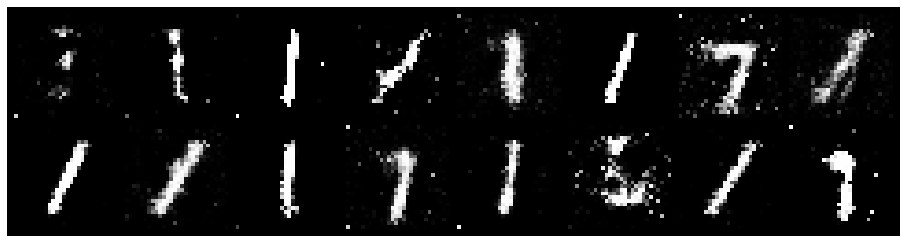

Epoch: [23/50], Batch Num: [0/600]
Discriminator Loss: 0.6342, Generator Loss: 2.2367
D(x): 0.8527, D(G(z)): 0.2601


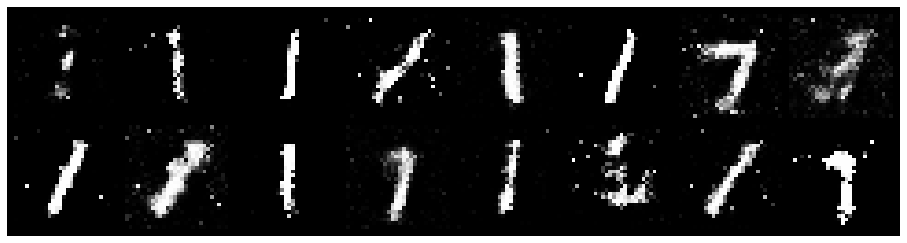

Epoch: [23/50], Batch Num: [300/600]
Discriminator Loss: 0.5386, Generator Loss: 2.0673
D(x): 0.8931, D(G(z)): 0.2679


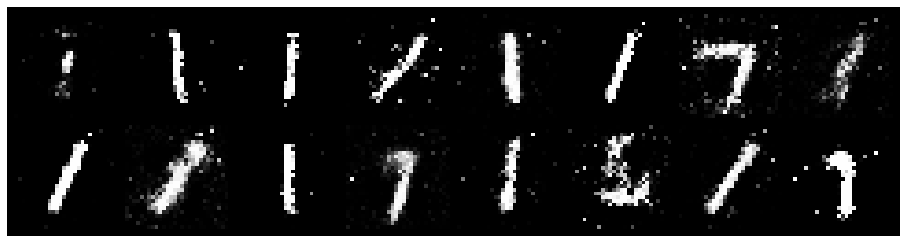

Epoch: [24/50], Batch Num: [0/600]
Discriminator Loss: 0.3941, Generator Loss: 4.1856
D(x): 0.8643, D(G(z)): 0.0948


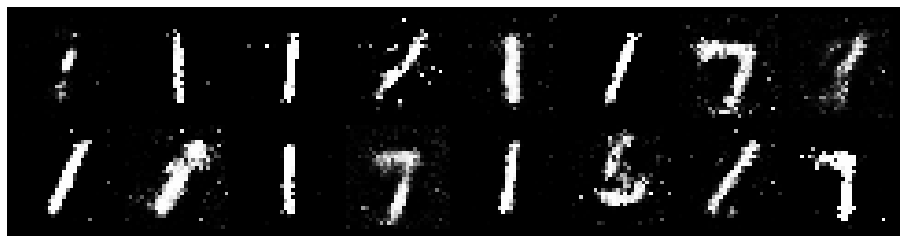

Epoch: [24/50], Batch Num: [300/600]
Discriminator Loss: 0.3538, Generator Loss: 2.5267
D(x): 0.8621, D(G(z)): 0.0957


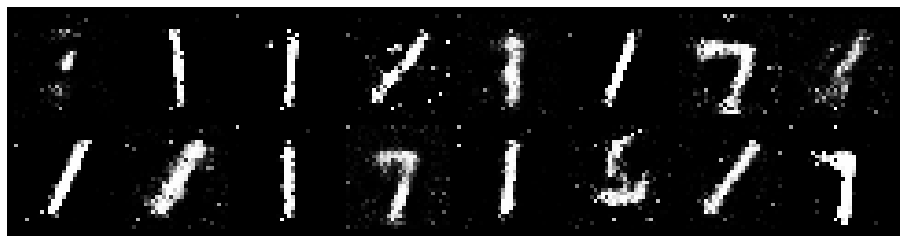

Epoch: [25/50], Batch Num: [0/600]
Discriminator Loss: 0.5856, Generator Loss: 3.0534
D(x): 0.8543, D(G(z)): 0.1729


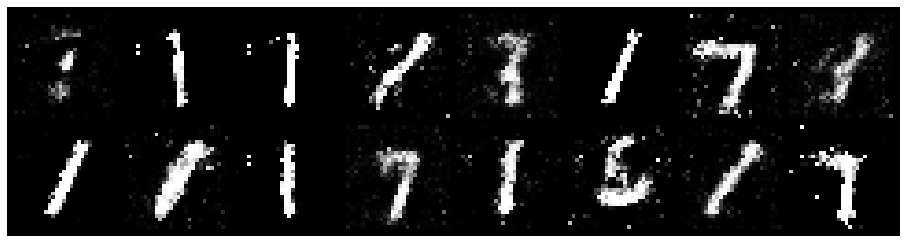

Epoch: [25/50], Batch Num: [300/600]
Discriminator Loss: 0.3380, Generator Loss: 6.6667
D(x): 0.8867, D(G(z)): 0.0843


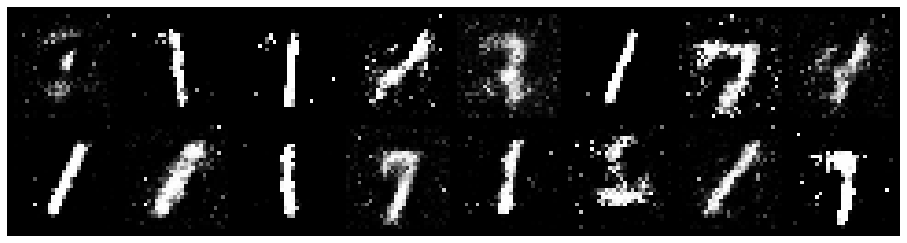

Epoch: [26/50], Batch Num: [0/600]
Discriminator Loss: 0.5520, Generator Loss: 4.7174
D(x): 0.7858, D(G(z)): 0.0468


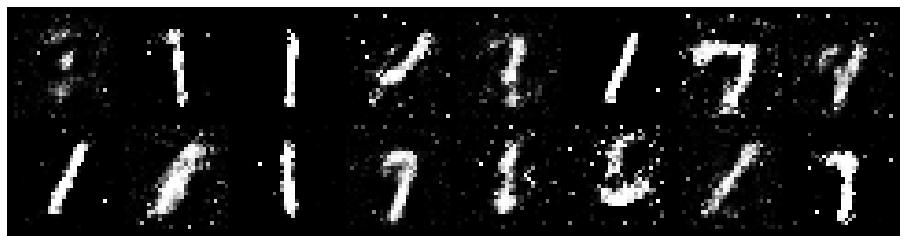

Epoch: [26/50], Batch Num: [300/600]
Discriminator Loss: 0.7752, Generator Loss: 2.1726
D(x): 0.7495, D(G(z)): 0.1555


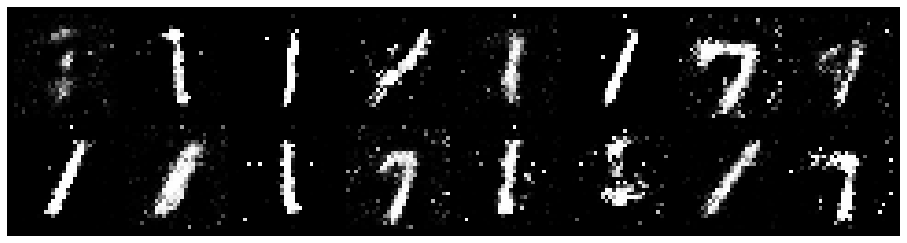

Epoch: [27/50], Batch Num: [0/600]
Discriminator Loss: 0.4186, Generator Loss: 2.9794
D(x): 0.8782, D(G(z)): 0.1438


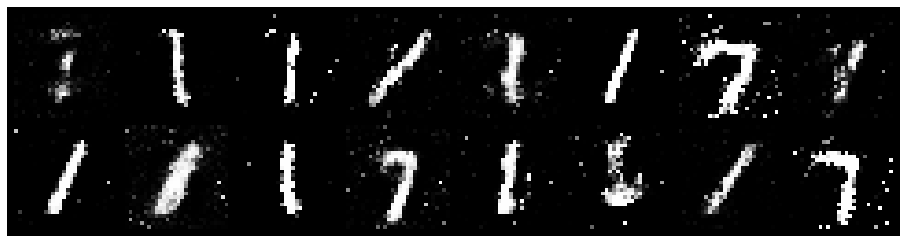

Epoch: [27/50], Batch Num: [300/600]
Discriminator Loss: 0.6441, Generator Loss: 4.4740
D(x): 0.7985, D(G(z)): 0.1396


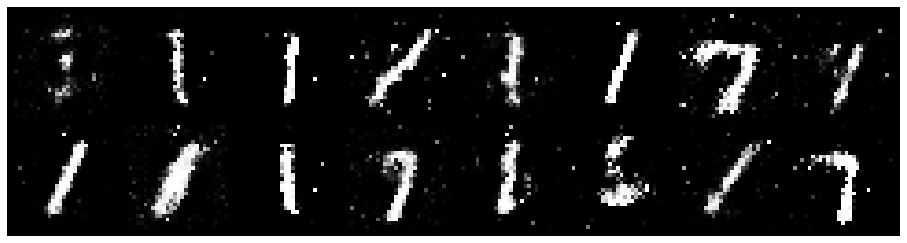

Epoch: [28/50], Batch Num: [0/600]
Discriminator Loss: 0.4735, Generator Loss: 2.9127
D(x): 0.8545, D(G(z)): 0.1556


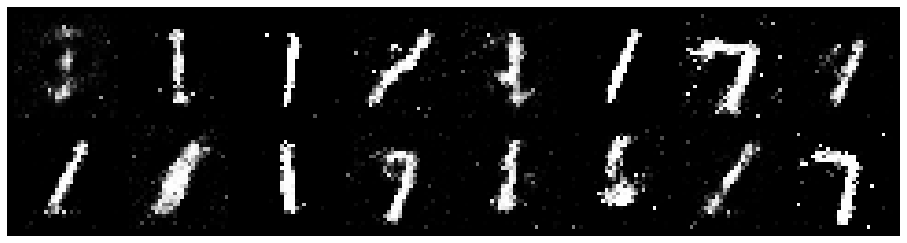

Epoch: [28/50], Batch Num: [300/600]
Discriminator Loss: 0.5937, Generator Loss: 2.9565
D(x): 0.8815, D(G(z)): 0.2812


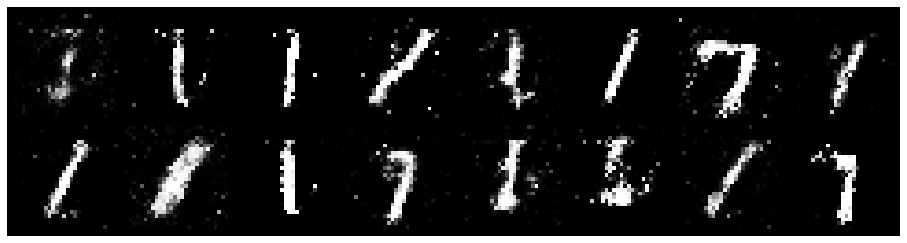

Epoch: [29/50], Batch Num: [0/600]
Discriminator Loss: 0.4176, Generator Loss: 2.1750
D(x): 0.8777, D(G(z)): 0.1494


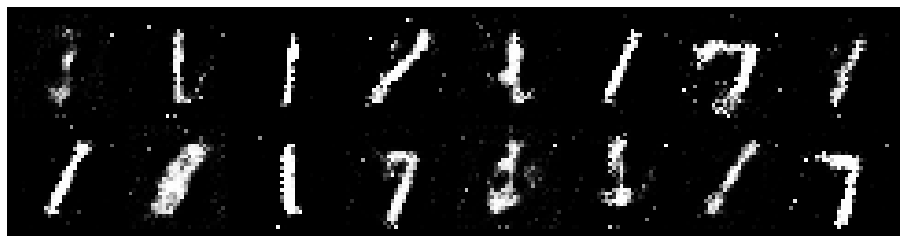

Epoch: [29/50], Batch Num: [300/600]
Discriminator Loss: 0.4898, Generator Loss: 2.9779
D(x): 0.8204, D(G(z)): 0.0914


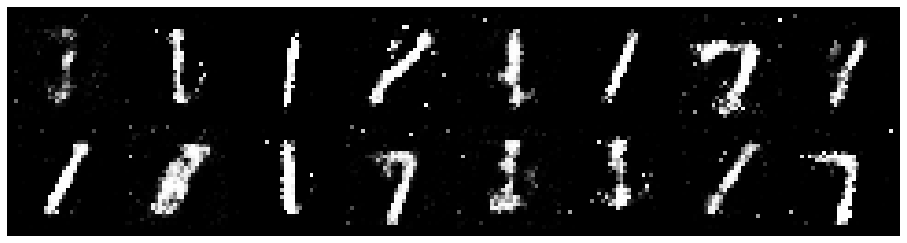

Epoch: [30/50], Batch Num: [0/600]
Discriminator Loss: 0.5772, Generator Loss: 2.3106
D(x): 0.8161, D(G(z)): 0.1345


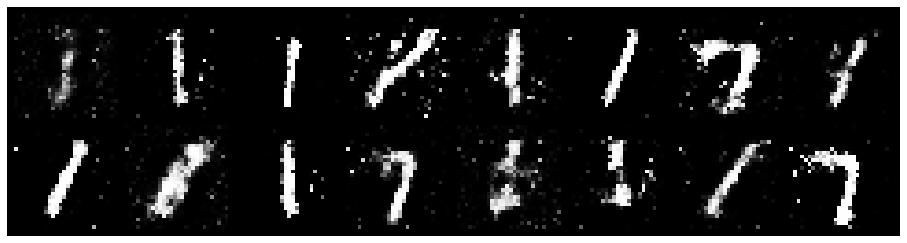

Epoch: [30/50], Batch Num: [300/600]
Discriminator Loss: 0.4170, Generator Loss: 2.2159
D(x): 0.8970, D(G(z)): 0.1999


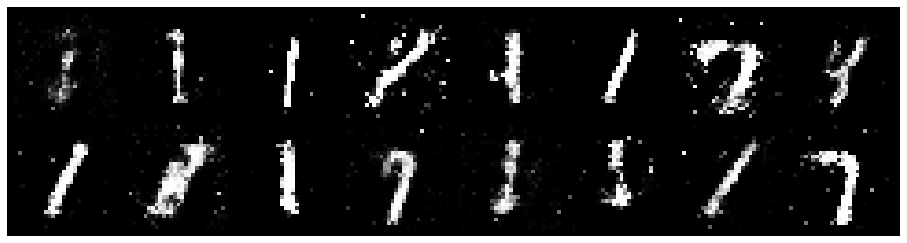

Epoch: [31/50], Batch Num: [0/600]
Discriminator Loss: 0.3844, Generator Loss: 3.6192
D(x): 0.8133, D(G(z)): 0.0743


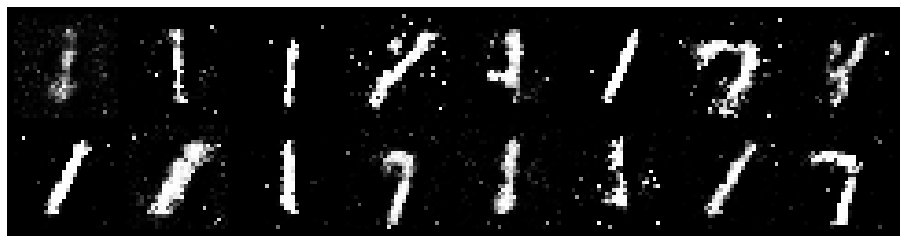

Epoch: [31/50], Batch Num: [300/600]
Discriminator Loss: 0.5025, Generator Loss: 1.8779
D(x): 0.9118, D(G(z)): 0.2470


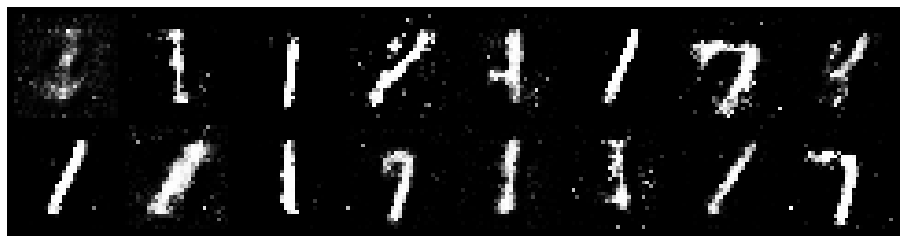

Epoch: [32/50], Batch Num: [0/600]
Discriminator Loss: 0.4742, Generator Loss: 2.5502
D(x): 0.8348, D(G(z)): 0.1055


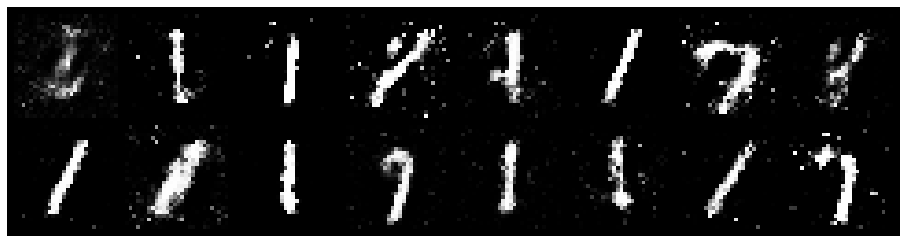

Epoch: [32/50], Batch Num: [300/600]
Discriminator Loss: 0.3474, Generator Loss: 2.6707
D(x): 0.9392, D(G(z)): 0.1784


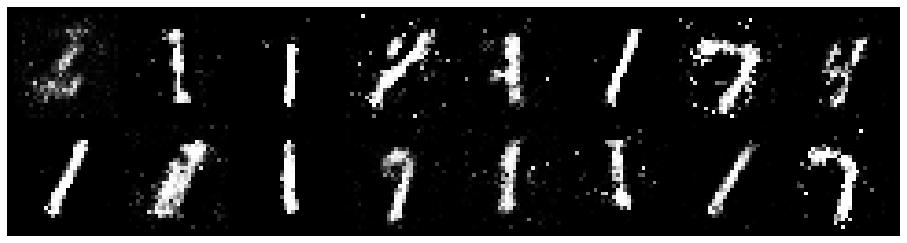

Epoch: [33/50], Batch Num: [0/600]
Discriminator Loss: 0.5148, Generator Loss: 2.6188
D(x): 0.8593, D(G(z)): 0.1695


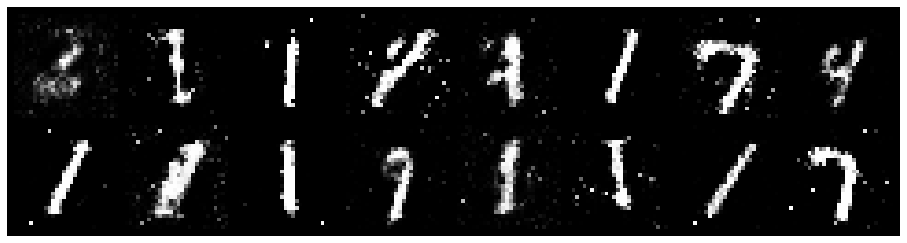

Epoch: [33/50], Batch Num: [300/600]
Discriminator Loss: 1.1606, Generator Loss: 3.2050
D(x): 0.6521, D(G(z)): 0.0845


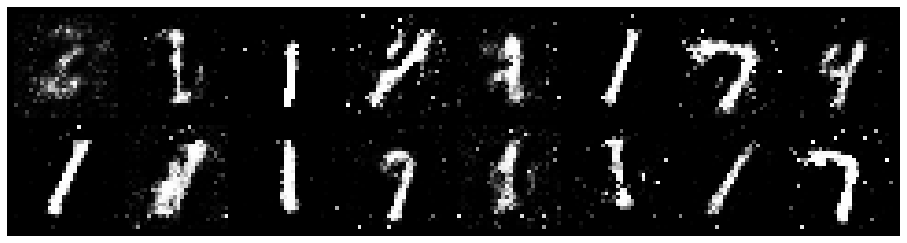

Epoch: [34/50], Batch Num: [0/600]
Discriminator Loss: 0.4465, Generator Loss: 3.8477
D(x): 0.8261, D(G(z)): 0.0776


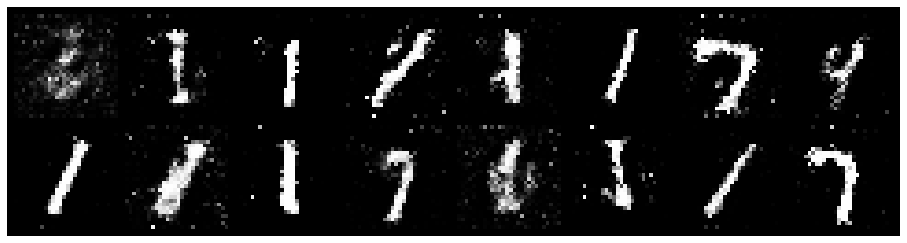

Epoch: [34/50], Batch Num: [300/600]
Discriminator Loss: 0.4286, Generator Loss: 3.3202
D(x): 0.8377, D(G(z)): 0.0711


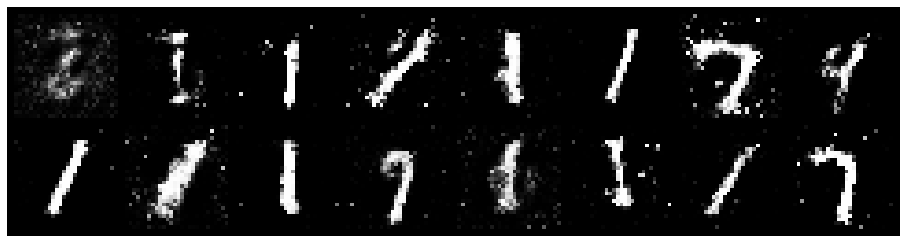

Epoch: [35/50], Batch Num: [0/600]
Discriminator Loss: 0.7681, Generator Loss: 2.1713
D(x): 0.8706, D(G(z)): 0.3248


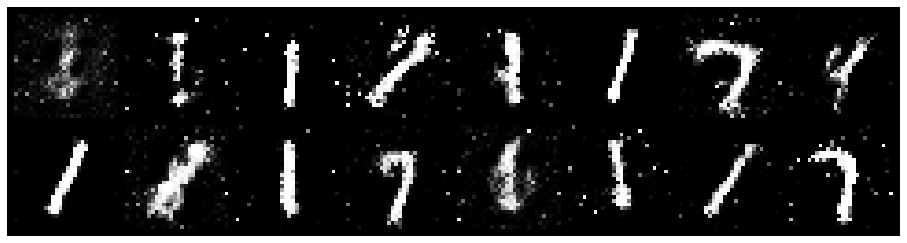

Epoch: [35/50], Batch Num: [300/600]
Discriminator Loss: 0.4683, Generator Loss: 1.9610
D(x): 0.9085, D(G(z)): 0.2254


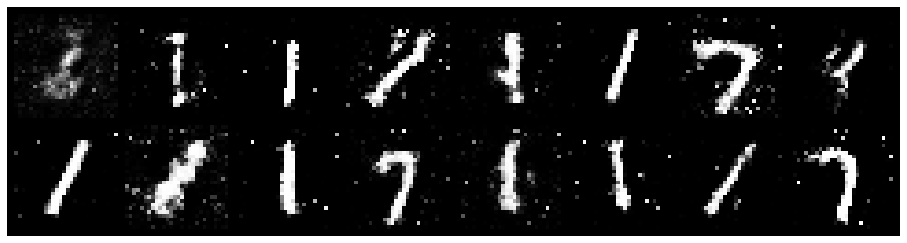

Epoch: [36/50], Batch Num: [0/600]
Discriminator Loss: 0.3888, Generator Loss: 4.3063
D(x): 0.9293, D(G(z)): 0.1853


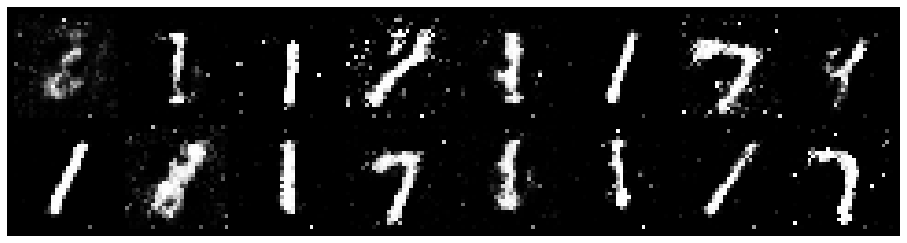

Epoch: [36/50], Batch Num: [300/600]
Discriminator Loss: 0.6087, Generator Loss: 1.6853
D(x): 0.8166, D(G(z)): 0.2107


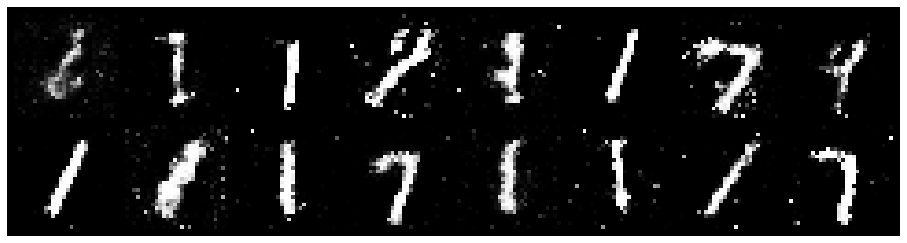

Epoch: [37/50], Batch Num: [0/600]
Discriminator Loss: 0.3570, Generator Loss: 2.7428
D(x): 0.9137, D(G(z)): 0.1570


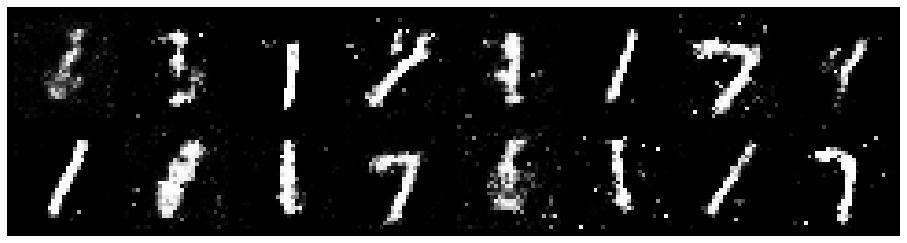

Epoch: [37/50], Batch Num: [300/600]
Discriminator Loss: 0.6315, Generator Loss: 2.7489
D(x): 0.8029, D(G(z)): 0.1752


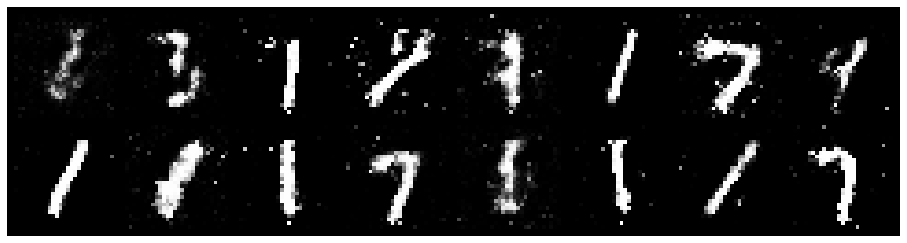

Epoch: [38/50], Batch Num: [0/600]
Discriminator Loss: 0.7052, Generator Loss: 1.5105
D(x): 0.8344, D(G(z)): 0.2881


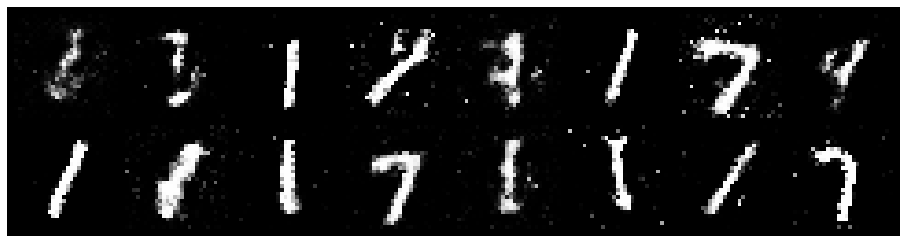

Epoch: [38/50], Batch Num: [300/600]
Discriminator Loss: 0.5603, Generator Loss: 2.3504
D(x): 0.7744, D(G(z)): 0.1624


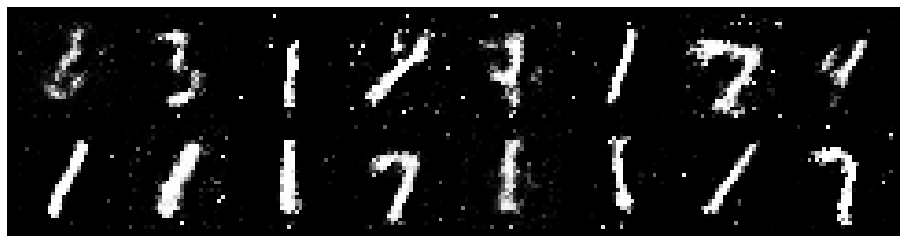

Epoch: [39/50], Batch Num: [0/600]
Discriminator Loss: 0.5795, Generator Loss: 3.0309
D(x): 0.7674, D(G(z)): 0.0454


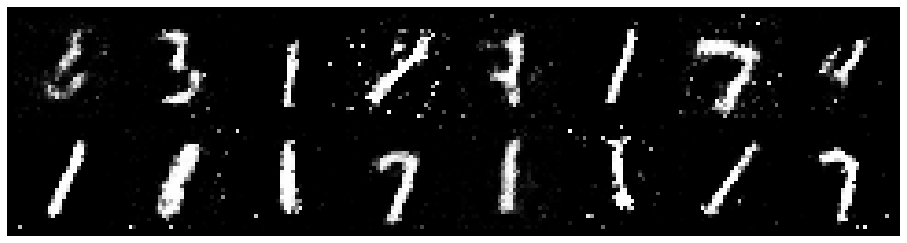

Epoch: [39/50], Batch Num: [300/600]
Discriminator Loss: 0.6800, Generator Loss: 1.8106
D(x): 0.7996, D(G(z)): 0.2373


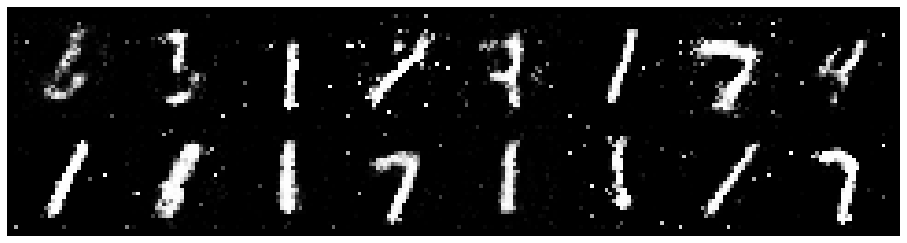

Epoch: [40/50], Batch Num: [0/600]
Discriminator Loss: 0.5582, Generator Loss: 2.2077
D(x): 0.8313, D(G(z)): 0.1657


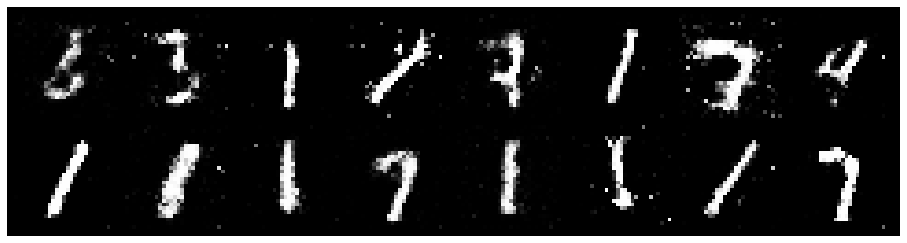

Epoch: [40/50], Batch Num: [300/600]
Discriminator Loss: 0.6426, Generator Loss: 1.8424
D(x): 0.8748, D(G(z)): 0.2801


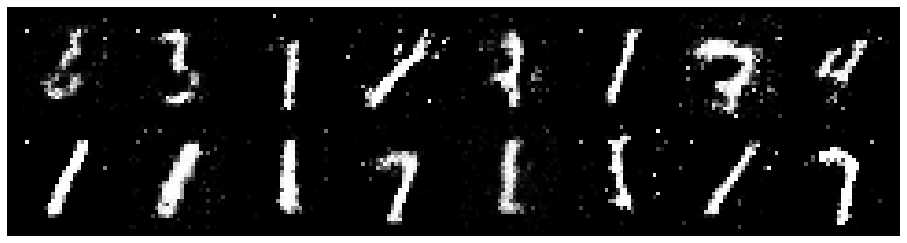

Epoch: [41/50], Batch Num: [0/600]
Discriminator Loss: 0.4438, Generator Loss: 3.3571
D(x): 0.8652, D(G(z)): 0.1550


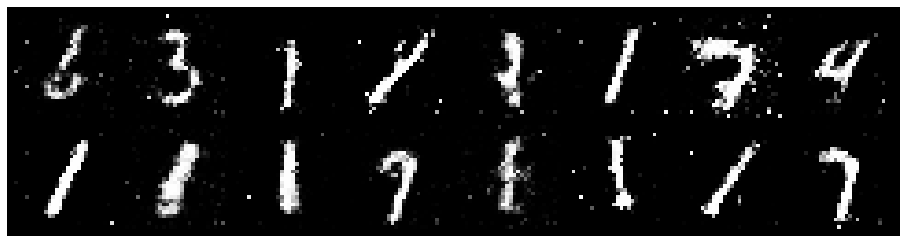

Epoch: [41/50], Batch Num: [300/600]
Discriminator Loss: 0.5053, Generator Loss: 2.1138
D(x): 0.8509, D(G(z)): 0.1913


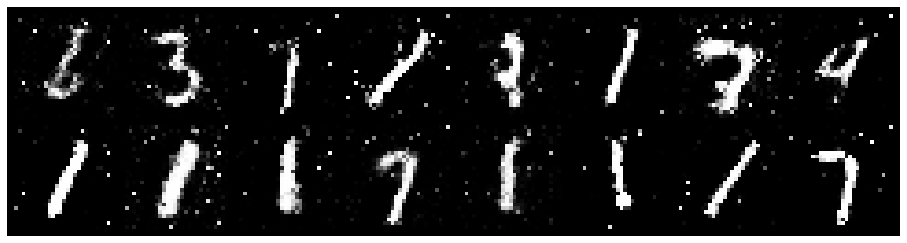

Epoch: [42/50], Batch Num: [0/600]
Discriminator Loss: 0.4469, Generator Loss: 3.8453
D(x): 0.8892, D(G(z)): 0.2005


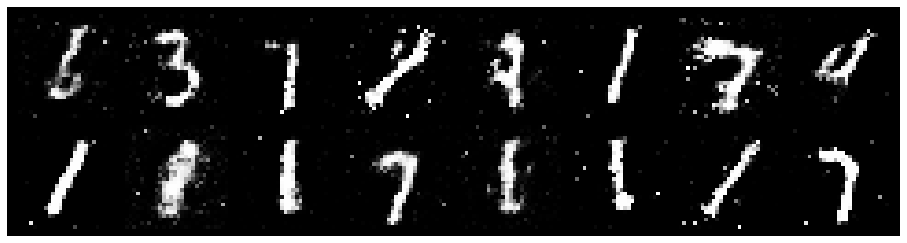

Epoch: [42/50], Batch Num: [300/600]
Discriminator Loss: 0.6404, Generator Loss: 2.2751
D(x): 0.7632, D(G(z)): 0.1392


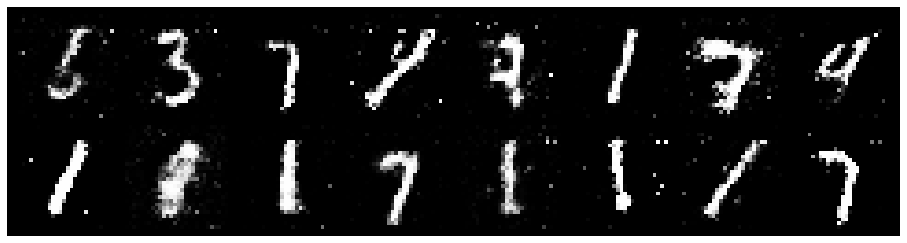

Epoch: [43/50], Batch Num: [0/600]
Discriminator Loss: 0.7887, Generator Loss: 1.4144
D(x): 0.8088, D(G(z)): 0.3035


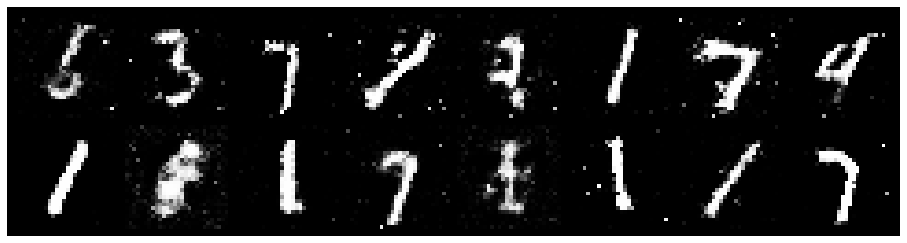

Epoch: [43/50], Batch Num: [300/600]
Discriminator Loss: 0.6281, Generator Loss: 2.8101
D(x): 0.8356, D(G(z)): 0.2489


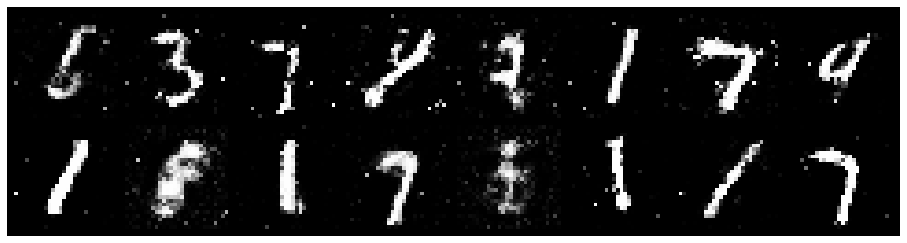

Epoch: [44/50], Batch Num: [0/600]
Discriminator Loss: 0.6352, Generator Loss: 2.5417
D(x): 0.8206, D(G(z)): 0.2239


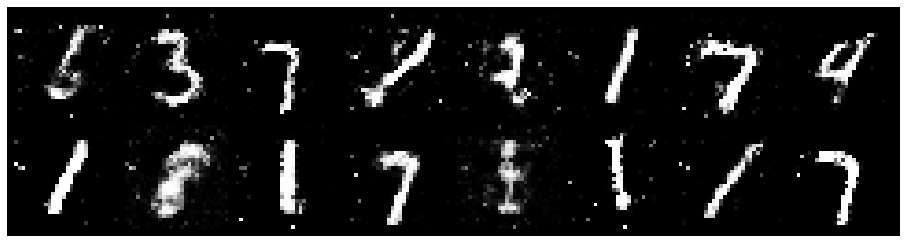

Epoch: [44/50], Batch Num: [300/600]
Discriminator Loss: 0.6364, Generator Loss: 1.9018
D(x): 0.8620, D(G(z)): 0.2665


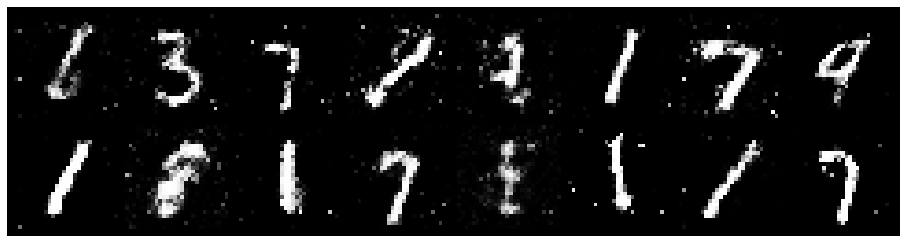

Epoch: [45/50], Batch Num: [0/600]
Discriminator Loss: 0.5714, Generator Loss: 2.0668
D(x): 0.7939, D(G(z)): 0.1929


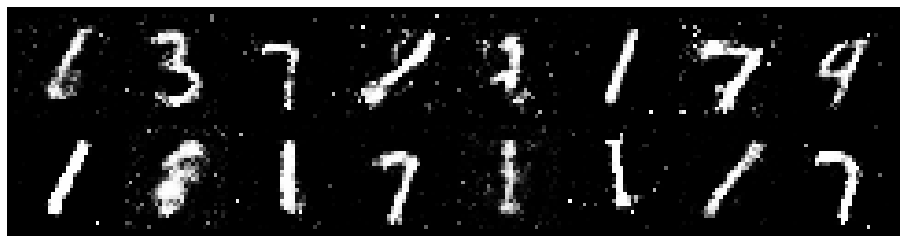

Epoch: [45/50], Batch Num: [300/600]
Discriminator Loss: 0.8368, Generator Loss: 2.0269
D(x): 0.8093, D(G(z)): 0.2743


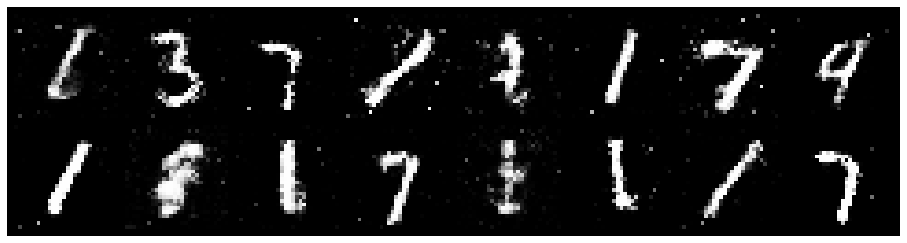

Epoch: [46/50], Batch Num: [0/600]
Discriminator Loss: 0.6839, Generator Loss: 1.2965
D(x): 0.8650, D(G(z)): 0.3311


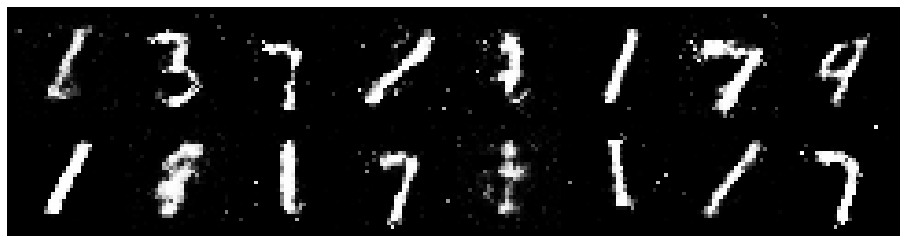

Epoch: [46/50], Batch Num: [300/600]
Discriminator Loss: 0.5140, Generator Loss: 3.0979
D(x): 0.8081, D(G(z)): 0.1278


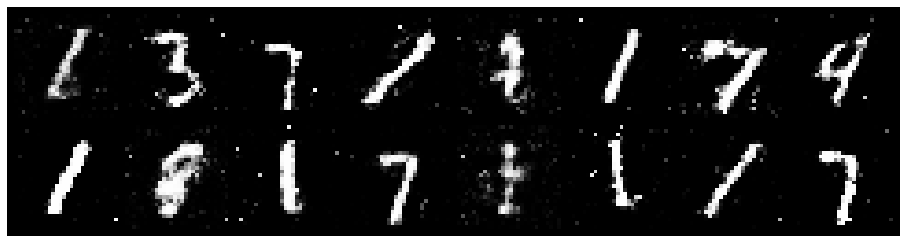

Epoch: [47/50], Batch Num: [0/600]
Discriminator Loss: 0.6771, Generator Loss: 2.1058
D(x): 0.8542, D(G(z)): 0.2991


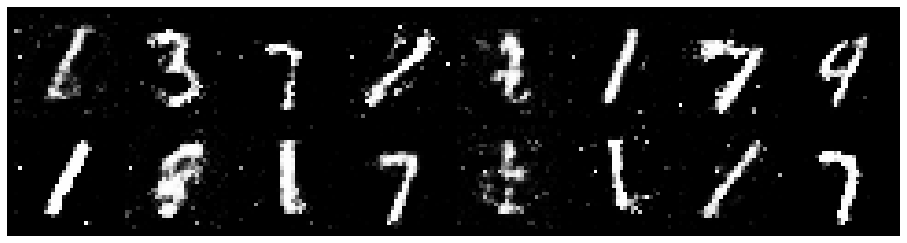

Epoch: [47/50], Batch Num: [300/600]
Discriminator Loss: 0.6251, Generator Loss: 1.9966
D(x): 0.8117, D(G(z)): 0.2505


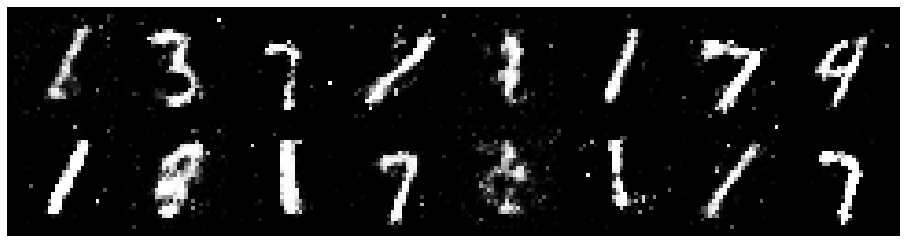

Epoch: [48/50], Batch Num: [0/600]
Discriminator Loss: 0.6365, Generator Loss: 2.4221
D(x): 0.8637, D(G(z)): 0.2810


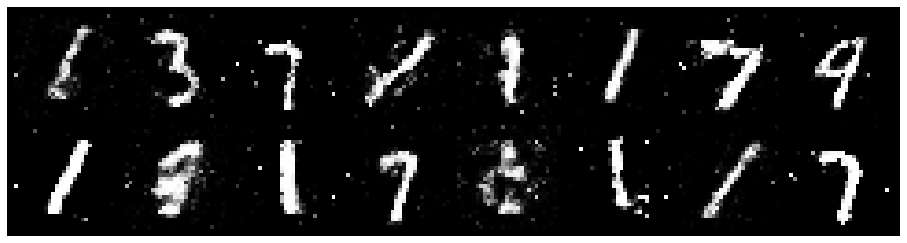

Epoch: [48/50], Batch Num: [300/600]
Discriminator Loss: 0.5198, Generator Loss: 1.5409
D(x): 0.8380, D(G(z)): 0.2199


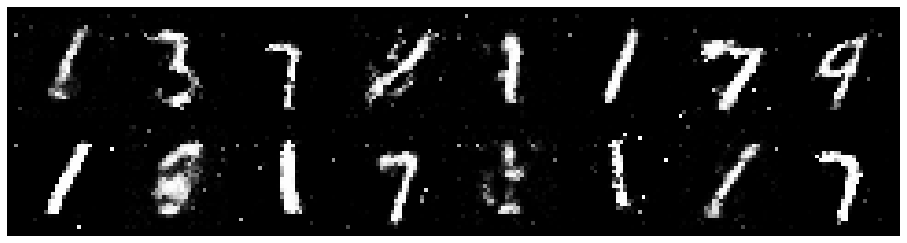

Epoch: [49/50], Batch Num: [0/600]
Discriminator Loss: 0.6120, Generator Loss: 2.7179
D(x): 0.8208, D(G(z)): 0.2242


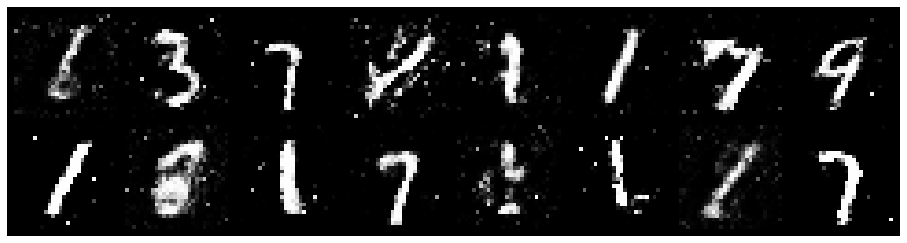

Epoch: [49/50], Batch Num: [300/600]
Discriminator Loss: 0.8548, Generator Loss: 3.9862
D(x): 0.8814, D(G(z)): 0.3208


In [88]:
# Create logger instance
logger = Logger(model_name='Vannila_GAN', data_name='MNIST')# Total number of epochs to train

num_epochs = 50

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)        # 1. Train Discriminator
        #print(N)
        real_sample = Variable(images_to_vectors(real_batch))        
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        G_sample = G(get_latent_sample(N)).detach()        
        
        # Train D
        d_loss, d_real_score, d_fake_score = train_D(D_optimizer, real_sample, G_sample)

        # 2. Train Generator        
        # Generate fake data
        G_sample = G(get_latent_sample(N))        
        
        # Train G
        g_loss = train_G(G_optimizer, G_sample)
        
        # Log batch error
        logger.log(d_loss, g_loss, epoch, n_batch, num_batches)        
        
        # Display Progress every few batches
        if (n_batch) % 300 == 0: 
            test_images = vectors_to_images(G(test_noise))
            test_images = test_images.data            
            
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_loss, g_loss, d_real_score, d_fake_score
            )

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


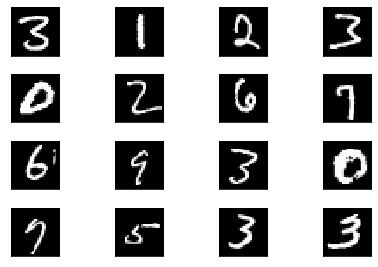

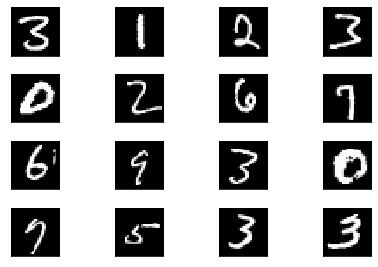

In [106]:
images, labels = next(iter(data_loader))
print(images.shape)
#plt.imshow(images[0].reshape(28,28), cmap="gray")

examples = enumerate(data_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

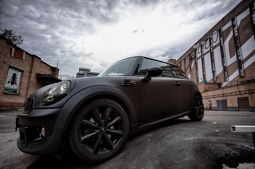

In [50]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = t.Tensor(3, 64, 64).normal_()
to_img(a)

# display imagefile
Image('ondemand/sr_data/train_LR/DIV2K_train_LR_x8/0100x8.png')

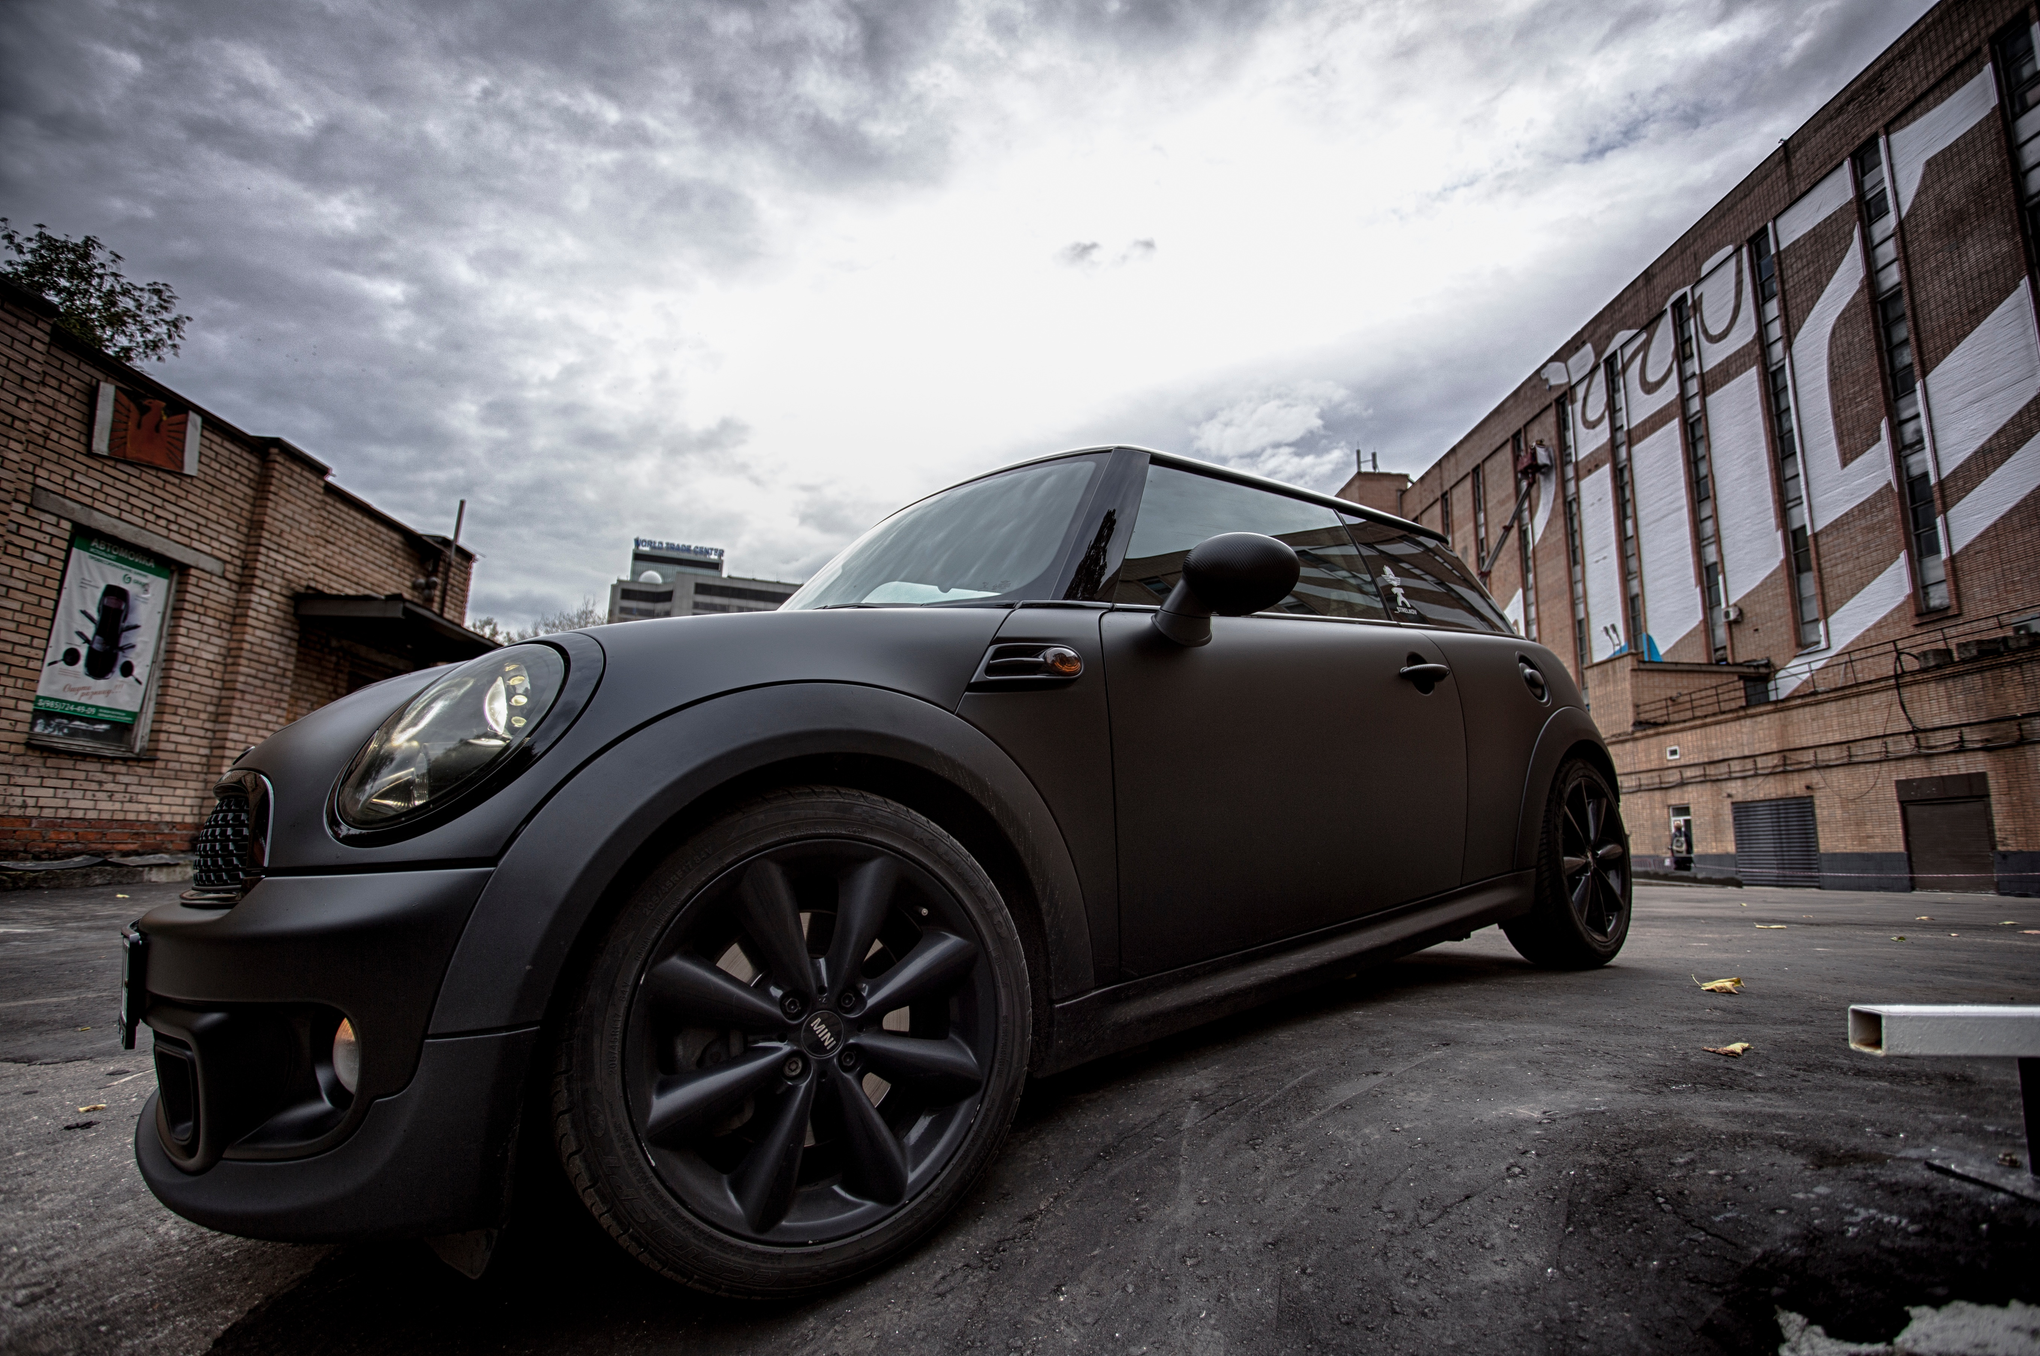

In [51]:
Image('ondemand/sr_data/train_HR/DIV2K_train_HR/0100.png')

This tutorial has been designed with help from the following websites:

a) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

b) https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f